# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

from alignparse import *

from Bio.Seq import Seq

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

import subprocess

Input data paths. Currently hardcoded.

In [2]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'
pacbio_mutations_csv = 'results/pacbio/scProgenyProduction_trial3_consensus_UMI_mutations.csv.gz'
coinfected_cells_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_coinfected_cells.csv.gz'
consensus_muts_by_cell_csv = 'results/pacbio/scProgenyProduction_trial3_consensus_muts_by_cell.csv'

Global variables for this notebook:

In [3]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_rich = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']

### Load data

**Transcriptome** viral barcode frequencies:

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCATCATTGCTT  uninfected                none         0.000111   
3      AAACGAAAGATGTTGA  uninfected                none         0.000161   
4      AAACGAAAGATGTTGA  uninfected                none         0.000161   
...                 ...         ...                 ...              ...   
10524  TTTGATCTCCCGTTCA  uninfected                none         0.000048   
10525  TTTGATCTCGCATTGA    infected                  wt         0.060937   
10526  TTTGGAGAGTTGCCTA  uninfected                none         0.000182   
10527  TTTGGAGGTATCGTTG    infected                  wt         0.023486   
10528  TTTGTTGAGTGCAGCA  uninfected                none         0.000059   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA              1            0.000021   
1      fluHA  TTTCGGTTGATTATTG              1            0.000021   
2      fluHA               NaN              0            0.000000   
3      fluHA  CACTGATCAGGAGGTG              1            0.000009   
4      fluHA  TTTCGGTTGATTATTG              1            0.000009   
...      ...               ...            ...                 ...   
10524  fluNA               NaN              0            0.000000   
10525  fluNA               NaN              0            0.000000   
10526  fluNA  TTGTGAGCGAAGTGCG              1            0.000015   
10527  fluNA  ACATCTTATTTACACG             39            0.000260   
10528  fluNA               NaN              0            0.000000   

       reject_uninfected  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False  
...                  ...  
10524              False  
10525              False  
10526              False  
10527               True  
10528              False  

[10529 rows x 9 columns]

**Progeny** viral barcode frequencies:

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_count': 'count_progeny',
                                           'mean_freq': 'freq_progeny'}))
display(progeny_viral_bc_freqs)

source infecting_viral_tag   gene     viral_barcode  \
0      second_infection                 syn  fluHA  AAAACCTTCCGTACGT   
1      second_infection                 syn  fluHA  AAAAGATCTTCGGTTT   
2      second_infection                 syn  fluHA  AAAAGGAAAGAAGTGC   
3      second_infection                 syn  fluHA  AAAATAAAATAATGTT   
4      second_infection                 syn  fluHA  AAAATATACGTAAATC   
...                 ...                 ...    ...               ...   
11347       supernatant                  wt  fluNA  TTTTCGTGAAAAGAGA   
11348       supernatant                  wt  fluNA  TTTTGCTTCGAGATAG   
11349       supernatant                  wt  fluNA  TTTTGGTTGTGAGGTG   
11350       supernatant                  wt  fluNA  TTTTGTTACATCATCT   
11351       supernatant                  wt  fluNA  TTTTTAGGGGTAACTG   

       count_progeny  freq_progeny  
0             1172.0  6.696768e-04  
1              529.0  8.867890e-04  
2             1015.0  8.053109e-04  
3               33.0  1.885609e-05  
4                0.5  2.856983e-07  
...              ...           ...  
11347         2638.5  1.747121e-03  
11348        22633.5  1.264800e-02  
11349            0.5  2.399886e-07  
11350            0.5  2.399886e-07  
11351            0.5  2.399886e-07  

[11352 rows x 6 columns]

Cell-gene matrix:

In [7]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 3372 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources.

In [8]:
assert transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription

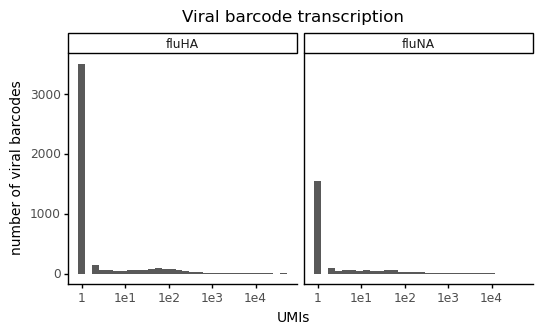

<ggplot: (8766305864789)>

In [9]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='UMIs',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

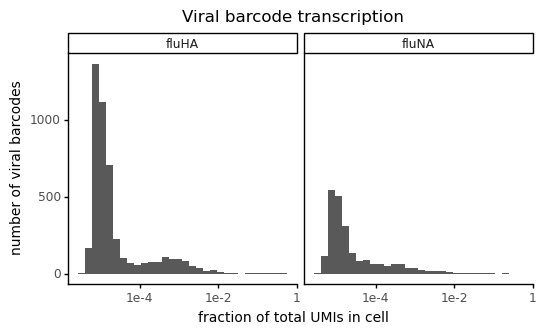

<ggplot: (8766313756811)>

In [10]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

#### Progeny production

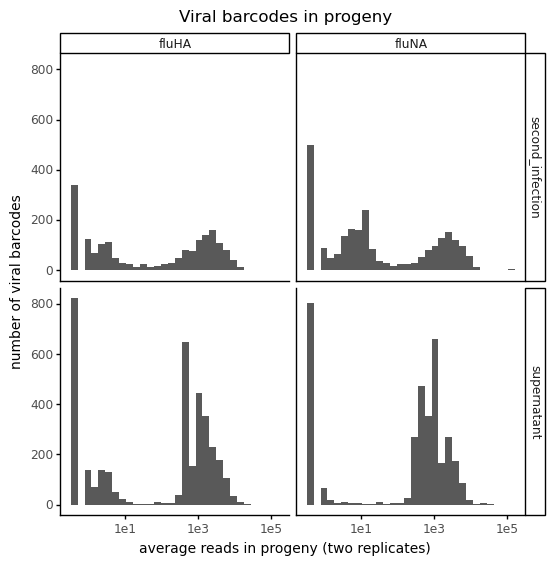

<ggplot: (8766305555017)>

In [11]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='count_progeny')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'Viral barcodes in progeny') +
       p9.labs(x='average reads in progeny (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

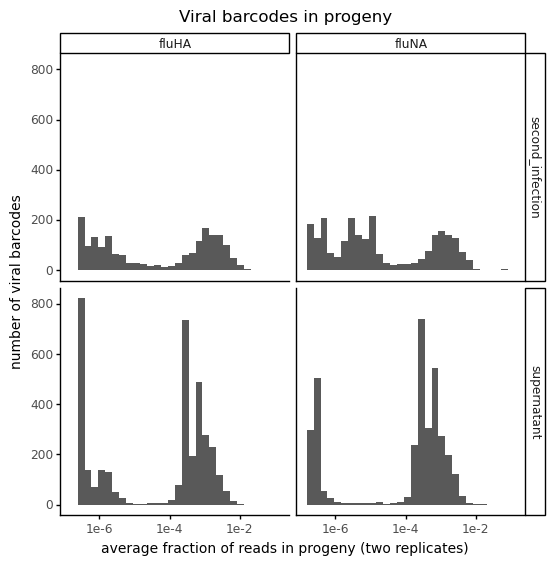

<ggplot: (8766305425279)>

In [12]:
fig = (p9.ggplot(progeny_viral_bc_freqs,
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'Viral barcodes in progeny') +
       p9.labs(x='average fraction of reads in progeny (two replicates)',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Process data
Next, I will merge the data into a few useable dataframes. I will perform calculations on these data that will help us visualize technical error and filter.

#### Merge all viral barcode data into a central dataframe called `viral_bc_freqs`

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Count in the transcriptome (`viral_bc_UMIs`)
7. Frequency in transcriptome (`frac_viral_bc_UMIs`)
8. Progeny sample source (`source`)
8. Count in the progeny sequencing (`count_progeny`)
9. Frequency in progeny sequencing (`freq_progeny`)

First, make two copies of the data in `transcritome_viral_bc_freqs`. Assign one to each progeny source (`supernatant` or `second_infection`).

In [13]:
transcriptome_viral_bc_freqs = (
    pd.concat([transcriptome_viral_bc_freqs
               .assign(source=source)
               for source in ['supernatant', 'second_infection']]))
transcriptome_viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCATCATTGCTT  uninfected                none         0.000111   
3      AAACGAAAGATGTTGA  uninfected                none         0.000161   
4      AAACGAAAGATGTTGA  uninfected                none         0.000161   
...                 ...         ...                 ...              ...   
10524  TTTGATCTCCCGTTCA  uninfected                none         0.000048   
10525  TTTGATCTCGCATTGA    infected                  wt         0.060937   
10526  TTTGGAGAGTTGCCTA  uninfected                none         0.000182   
10527  TTTGGAGGTATCGTTG    infected                  wt         0.023486   
10528  TTTGTTGAGTGCAGCA  uninfected                none         0.000059   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA              1            0.000021   
1      fluHA  TTTCGGTTGATTATTG              1            0.000021   
2      fluHA               NaN              0            0.000000   
3      fluHA  CACTGATCAGGAGGTG              1            0.000009   
4      fluHA  TTTCGGTTGATTATTG              1            0.000009   
...      ...               ...            ...                 ...   
10524  fluNA               NaN              0            0.000000   
10525  fluNA               NaN              0            0.000000   
10526  fluNA  TTGTGAGCGAAGTGCG              1            0.000015   
10527  fluNA  ACATCTTATTTACACG             39            0.000260   
10528  fluNA               NaN              0            0.000000   

       reject_uninfected            source  
0                  False       supernatant  
1                  False       supernatant  
2                  False       supernatant  
3                  False       supernatant  
4                  False       supernatant  
...                  ...               ...  
10524              False  second_infection  
10525              False  second_infection  
10526              False  second_infection  
10527               True  second_infection  
10528              False  second_infection  

[21058 rows x 10 columns]

Then, do the merge

In [14]:
viral_bc_freqs = pd.merge(
    left=transcriptome_viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag', 'source'])

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      GTTGAACTCTATGTGG  uninfected                none         0.000072   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACGAAAGATGTTGA  uninfected                none         0.000161   
4      AAAGAACTCGAAGAAT  uninfected                none         0.000101   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  GGAGCATAGATCAGGA            1.0            0.000009   
2      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
3      fluHA  TTTCGGTTGATTATTG            1.0            0.000009   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000017   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected       source  count_progeny  freq_progeny  
0                 False  supernatant            NaN           NaN  
1                 False  supernatant            NaN           NaN  
2                 False  supernatant            NaN           NaN  
3                 False  supernatant            NaN           NaN  
4                 False  supernatant            NaN           NaN  
...                 ...          ...            ...           ...  
31696               NaN  supernatant         7457.0  4.057614e-03  
31697               NaN  supernatant         2638.5  1.747121e-03  
31698               NaN  supernatant            0.5  2.399886e-07  
31699               NaN  supernatant            0.5  2.399886e-07  
31700               NaN  supernatant            0.5  2.399886e-07  

[31701 rows x 12 columns]

Fill `NA` values in progeny with `0`. It is meaningful if a viral barcode is seen in the transcriptome but absent from the supernatant; no progeny was produced by that infected cell.

In [15]:
viral_bc_freqs = viral_bc_freqs

viral_bc_freqs[['count_progeny', 'freq_progeny']] = (
    viral_bc_freqs[['count_progeny', 'freq_progeny']]
    .fillna(0)
)

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      GTTGAACTCTATGTGG  uninfected                none         0.000072   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACGAAAGATGTTGA  uninfected                none         0.000161   
4      AAAGAACTCGAAGAAT  uninfected                none         0.000101   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  GGAGCATAGATCAGGA            1.0            0.000009   
2      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
3      fluHA  TTTCGGTTGATTATTG            1.0            0.000009   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000017   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected       source  count_progeny  freq_progeny  
0                 False  supernatant            0.0  0.000000e+00  
1                 False  supernatant            0.0  0.000000e+00  
2                 False  supernatant            0.0  0.000000e+00  
3                 False  supernatant            0.0  0.000000e+00  
4                 False  supernatant            0.0  0.000000e+00  
...                 ...          ...            ...           ...  
31696               NaN  supernatant         7457.0  4.057614e-03  
31697               NaN  supernatant         2638.5  1.747121e-03  
31698               NaN  supernatant            0.5  2.399886e-07  
31699               NaN  supernatant            0.5  2.399886e-07  
31700               NaN  supernatant            0.5  2.399886e-07  

[31701 rows x 12 columns]

Get total UMIs per cell. Get viral UMI counts and fractions per cell. Assert that these match what is already found in `viral_bc_freqs`:

In [16]:
umi_counts = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                       .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            )
    )

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=umi_counts,
    how='outer',
    on=['cell_barcode'])

test_viral_frac_UMIs = pd.Series(
    viral_bc_freqs['viral_UMIs'] / viral_bc_freqs['total_UMIs'],
    name='frac_viral_UMIs')

pd.testing.assert_series_equal(
    test_viral_frac_UMIs, viral_bc_freqs['frac_viral_UMIs'])

viral_bc_freqs

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  count_progeny  freq_progeny  \
0                 False       supernatant            0.0  0.000000e+00   
1                 False       supernatant            0.0  0.000000e+00   
2                 False       supernatant            0.0  0.000000e+00   
3                 False  second_infection            0.0  0.000000e+00   
4                 False  second_infection            0.0  0.000000e+00   
...                 ...               ...            ...           ...   
31696               NaN       supernatant         7457.0  4.057614e-03   
31697               NaN       supernatant         2638.5  1.747121e-03   
31698               NaN       supernatant            0.5  2.399886e-07   
31699               NaN       supernatant            0.5  2.399886e-07   
31700               NaN       supernatant            0.5  2.399886e-07   

       total_UMIs  viral_UMIs  
0         47873.0         6.0  
1         47873.0         6.0  
2         47873.0         6.0  
3         47873.0         6.0  
4         47873.0         6.0  
...           ...         ...  
31696         NaN         NaN  
31697         NaN         NaN  
31698         NaN         NaN  
31699         NaN         NaN  
31700         NaN         NaN  

[31701 rows x 14 columns]

Do a quick check to make sure that the transcriptome measures ('infected', 'infecting_viral_tag', 'frac_viral_UMIs', 'total_UMIs', and 'viral_UMIs') are all the same for each cell barcode.

In [17]:
per_cell_measures = ['infected',
                     'infecting_viral_tag',
                     'frac_viral_UMIs',
                     'total_UMIs',
                     'viral_UMIs']

print('Checking that every cell is consistent '
      'with regard to the following measures:')
for measure in per_cell_measures:
    print('\n'+measure)
    print(all(viral_bc_freqs.groupby('cell_barcode')
              [f'{measure}'].nunique() == 1))
    assert all(viral_bc_freqs.groupby('cell_barcode') \
               [f'{measure}'].nunique() == 1)

Checking that every cell is consistent with regard to the following measures:

infected
True

infecting_viral_tag
True

frac_viral_UMIs
True

total_UMIs
True

viral_UMIs
True


#### Raw correlation of viral transcription and progeny production
Plot raw data:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


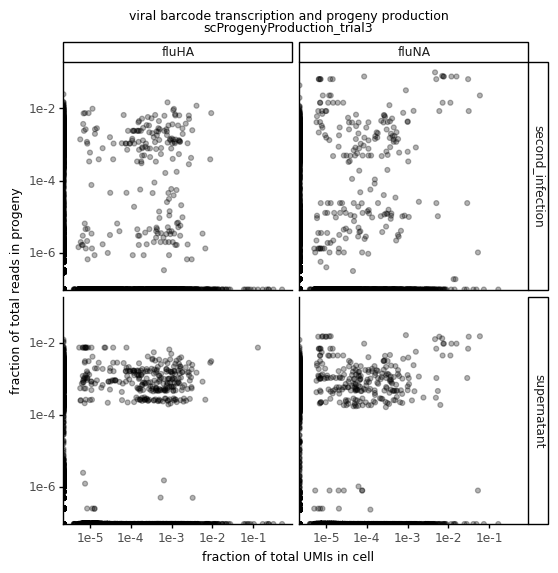

<ggplot: (8765622443457)>

In [18]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode transcription and progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Plot annotated by infection status

In [19]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode transcription and progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


TypeError: '<' not supported between instances of 'int' and 'str'

#### Plot annotated by variant

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


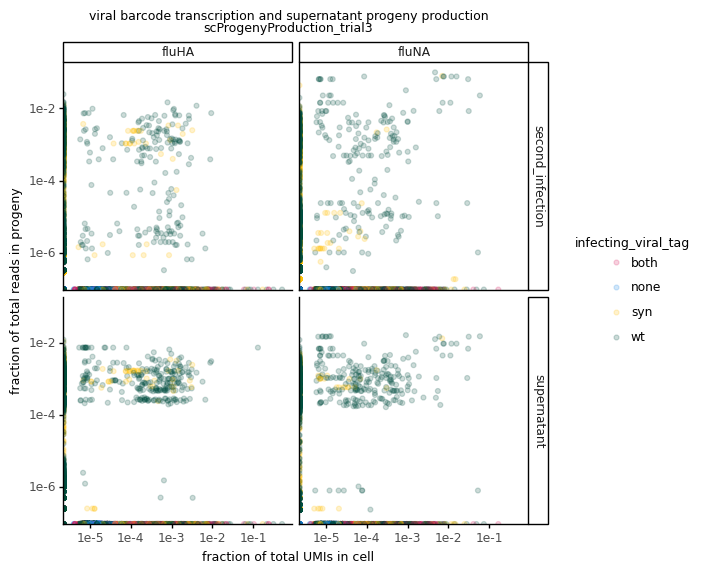

<ggplot: (8765620410706)>

In [20]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.2) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode transcription and supernatant progeny production\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE_rich[0:]))
display(fig)

#### Significant viral barcodes found above background frequency in uninfected cells
During viral barcode processing from the transcriptome, the frequency of viral barcodes is calculated in uninfected cells. A poisson distribution is built around the expected number of UMIs for each cell-gene, and viral barcodes are called as significant if they reject the null hypothesis that they are pulled from this distribution.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


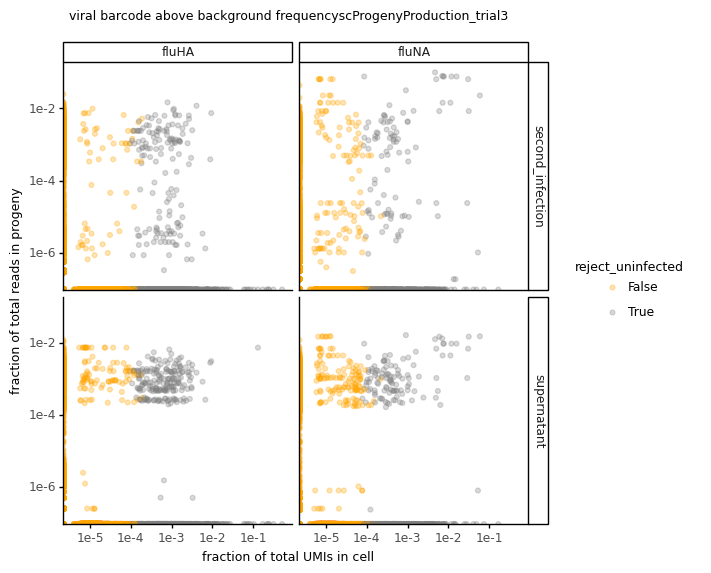

<ggplot: (8765622015862)>

In [21]:
fig = (p9.ggplot((viral_bc_freqs.fillna(0)),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='reject_uninfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle('viral barcode above background frequency'
                  f'{expt}\n') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral barcode sharing across cells
How often is a significant viral barcode found in more than one cell? This should be very unlikely in a low MOI infection.

In [22]:
n_cell_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  count_progeny  freq_progeny  \
0                 False       supernatant            0.0  0.000000e+00   
1                 False       supernatant            0.0  0.000000e+00   
2                 False       supernatant            0.0  0.000000e+00   
3                 False  second_infection            0.0  0.000000e+00   
4                 False  second_infection            0.0  0.000000e+00   
...                 ...               ...            ...           ...   
31696               NaN       supernatant         7457.0  4.057614e-03   
31697               NaN       supernatant         2638.5  1.747121e-03   
31698               NaN       supernatant            0.5  2.399886e-07   
31699               NaN       supernatant            0.5  2.399886e-07   
31700               NaN       supernatant            0.5  2.399886e-07   

       total_UMIs  viral_UMIs  n_cell_bc  
0         47873.0         6.0        NaN  
1         47873.0         6.0        NaN  
2         47873.0         6.0        NaN  
3         47873.0         6.0        NaN  
4         47873.0         6.0        NaN  
...           ...         ...        ...  
31696         NaN         NaN        NaN  
31697         NaN         NaN        NaN  
31698         NaN         NaN        NaN  
31699         NaN         NaN        NaN  
31700         NaN         NaN        NaN  

[31701 rows x 15 columns]

Plot distribution of cell barcode per viral barcode.

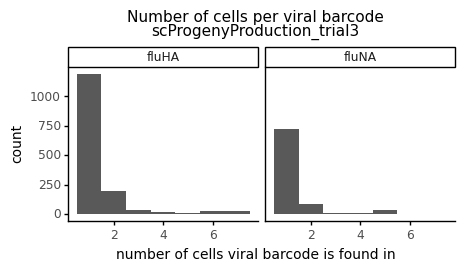

<ggplot: (8766305489933)>

In [23]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('number of cells viral barcode is found in') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label viral barcodes that are found in more than 1 cells.

In [24]:
viral_bc_freqs['gt1_cell'] = (
    viral_bc_freqs['n_cell_bc'] > 1)

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  count_progeny  freq_progeny  \
0                 False       supernatant            0.0  0.000000e+00   
1                 False       supernatant            0.0  0.000000e+00   
2                 False       supernatant            0.0  0.000000e+00   
3                 False  second_infection            0.0  0.000000e+00   
4                 False  second_infection            0.0  0.000000e+00   
...                 ...               ...            ...           ...   
31696               NaN       supernatant         7457.0  4.057614e-03   
31697               NaN       supernatant         2638.5  1.747121e-03   
31698               NaN       supernatant            0.5  2.399886e-07   
31699               NaN       supernatant            0.5  2.399886e-07   
31700               NaN       supernatant            0.5  2.399886e-07   

       total_UMIs  viral_UMIs  n_cell_bc  gt1_cell  
0         47873.0         6.0        NaN     False  
1         47873.0         6.0        NaN     False  
2         47873.0         6.0        NaN     False  
3         47873.0         6.0        NaN     False  
4         47873.0         6.0        NaN     False  
...           ...         ...        ...       ...  
31696         NaN         NaN        NaN     False  
31697         NaN         NaN        NaN     False  
31698         NaN         NaN        NaN     False  
31699         NaN         NaN        NaN     False  
31700         NaN         NaN        NaN     False  

[31701 rows x 16 columns]

Plot number of viral barcodes that were found in more than 1 cell:

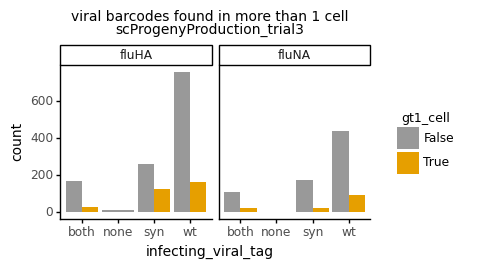

<ggplot: (8765622025735)>

In [25]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('(reject_uninfected == True) and '
                         '(cell_barcode.notna())',
                         engine='python')),
                 p9.aes(x='infecting_viral_tag',
                        fill='gt1_cell')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('viral barcodes found in more than 1 cell\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

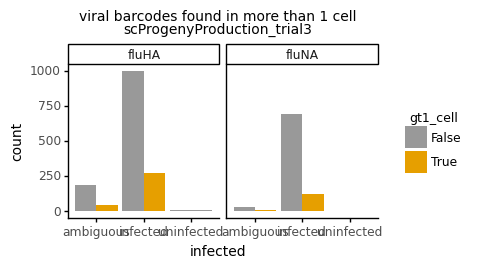

<ggplot: (8766305573160)>

In [26]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('(reject_uninfected == True) and '
                         '(cell_barcode.notna())',
                         engine='python')),
                 p9.aes(x='infected',
                        fill='gt1_cell')) +
       p9.geom_bar(stat='count', position='dodge') +
       p9.ggtitle('viral barcodes found in more than 1 cell\n'
                  f'{expt}') +
       p9.facet_grid('~gene') +
       p9.theme(figure_size=(4, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Plot annotated with significant viral barcodes found in more than one cell

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


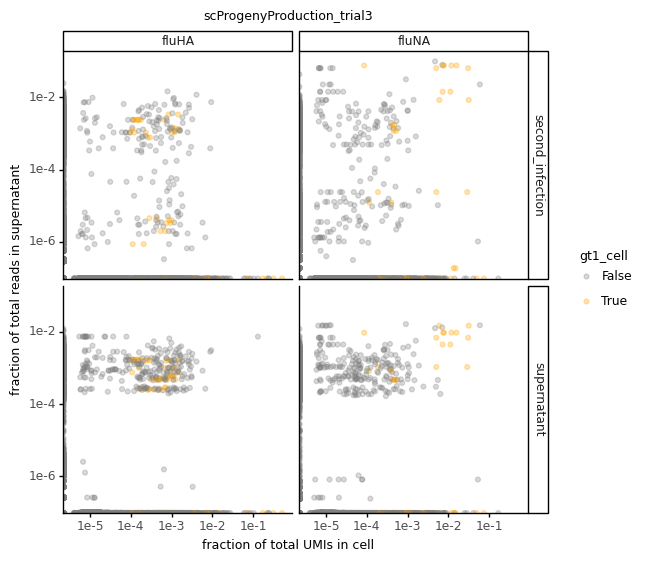

<ggplot: (8765619478592)>

In [27]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcodes per cell
Count the number of significant viral barcodes (above background) in each cell on each segment.

In [28]:
n_viral_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'cell_barcode',
                       'reject_uninfected'])
             ['viral_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'viral_barcode': 'n_viral_bc'}))

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_viral_bc,
    on=['infecting_viral_tag',
        'gene',
        'cell_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  count_progeny  freq_progeny  \
0                 False       supernatant            0.0  0.000000e+00   
1                 False       supernatant            0.0  0.000000e+00   
2                 False       supernatant            0.0  0.000000e+00   
3                 False  second_infection            0.0  0.000000e+00   
4                 False  second_infection            0.0  0.000000e+00   
...                 ...               ...            ...           ...   
31696               NaN       supernatant         7457.0  4.057614e-03   
31697               NaN       supernatant         2638.5  1.747121e-03   
31698               NaN       supernatant            0.5  2.399886e-07   
31699               NaN       supernatant            0.5  2.399886e-07   
31700               NaN       supernatant            0.5  2.399886e-07   

       total_UMIs  viral_UMIs  n_cell_bc  gt1_cell  n_viral_bc  
0         47873.0         6.0        NaN     False         NaN  
1         47873.0         6.0        NaN     False         NaN  
2         47873.0         6.0        NaN     False         NaN  
3         47873.0         6.0        NaN     False         NaN  
4         47873.0         6.0        NaN     False         NaN  
...           ...         ...        ...       ...         ...  
31696         NaN         NaN        NaN     False         NaN  
31697         NaN         NaN        NaN     False         NaN  
31698         NaN         NaN        NaN     False         NaN  
31699         NaN         NaN        NaN     False         NaN  
31700         NaN         NaN        NaN     False         NaN  

[31701 rows x 17 columns]

Plot distribution of viral barcode per cell.

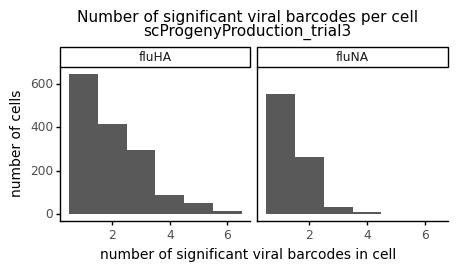

<ggplot: (8765606195044)>

In [29]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_viral_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of significant viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('number of significant viral barcodes in cell') +
       p9.ylab('number of cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Annotate cells as coinfected
I will label a cell as coinfected if either `fluHA` segment or `fluNA` segment has more than 1 significant viral barcode.

In [30]:
coinfected_cells = (
    viral_bc_freqs
    .query('infected == "infected"')
    [['cell_barcode',
      'infecting_viral_tag',
      'gene',
      'n_viral_bc']]
    .drop_duplicates()
    .dropna()
    .pivot(
       index=['cell_barcode', 'infecting_viral_tag'],
       columns=['gene'],
       values='n_viral_bc')
    .reset_index()
    .rename(columns={'gene':''})
    .fillna(0)
)

coinfected_cells['coinfected'] = (
    (coinfected_cells['fluHA'] > 1) |
    (coinfected_cells['fluNA'] > 1)
)

coinfected_cells

gene      cell_barcode infecting_viral_tag  fluHA  fluNA  coinfected
0     AAACGAAGTACTTCCC                both    0.0    1.0       False
1     AAACGAAGTAGACGTG                  wt    1.0    1.0       False
2     AAAGGATTCTGATGGT                 syn    1.0    1.0       False
3     AAAGGGCCAGGCTACC                  wt    3.0    1.0        True
4     AAAGGGCTCCGCACTT                  wt    2.0    0.0        True
..                 ...                 ...    ...    ...         ...
445   TTTAGTCCATCATCCC                  wt    1.0    2.0        True
446   TTTAGTCGTGCTCCGA                  wt    1.0    0.0       False
447   TTTCACAAGCCAAGCA                  wt    1.0    1.0       False
448   TTTGATCTCGCATTGA                  wt    1.0    0.0       False
449   TTTGGAGGTATCGTTG                  wt    1.0    1.0       False

[450 rows x 5 columns]

Plot number of cells called as coinfected:

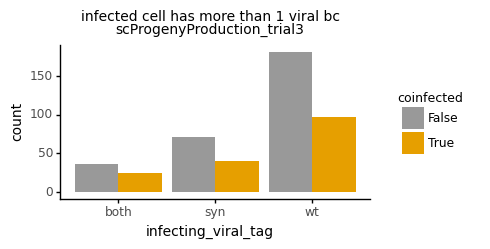

<ggplot: (8765619500195)>

In [31]:
fig = (p9.ggplot(coinfected_cells,
                 p9.aes(x='infecting_viral_tag',
                        fill='coinfected')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('infected cell has more than 1 viral bc\n'
                         f'{expt}') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Plot number of viral barcodes on each barcoded segment:

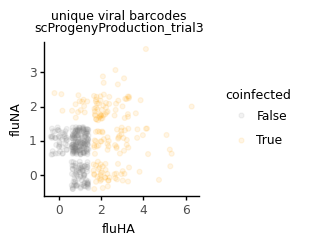

<ggplot: (8765606200899)>

In [32]:
fig = (p9.ggplot(coinfected_cells,
                 p9.aes(x='fluHA',
                        y='fluNA',
                        color='coinfected')) +
       p9.geom_jitter(alpha=0.1) +
       p9.ggtitle('unique viral barcodes\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

Integrate coinfection call into viral_bc_freqs:

In [33]:
viral_bc_freqs =(
  pd.merge(
    left=viral_bc_freqs,
    right=coinfected_cells[['cell_barcode', 'coinfected']],
    how='left',
    on=['cell_barcode'],
    validate='many_to_one'))

viral_bc_freqs['coinfected'] = viral_bc_freqs['coinfected'].fillna(False)

viral_bc_freqs.groupby(['infected', 'coinfected'])['cell_barcode'].nunique()

infected    coinfected
ambiguous   False          114
infected    False          317
            True           162
uninfected  False         2779
Name: cell_barcode, dtype: int64

#### Plot annotated highlighting cells with more than 1 significant viral barcode

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


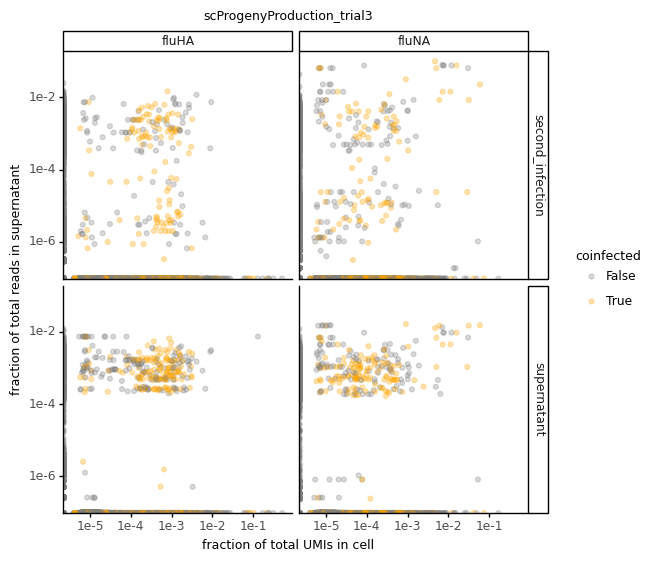

<ggplot: (8765606232739)>

In [34]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='coinfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Viral barcode rank in cell
I will rank each viral barcode in each cell-gene. I will see what fraction of all viral barcode UMIs each viral barcode accounts for.

To do this, I will:
* Group viral barcodes by cell-gene
* Sum fraction of cell UMIs that are assigned to **significant** viral barcodes in that cell-gene
* Rank only viral barcodes **that are significant above uninfected background**

Sum all **significant** viral bc freqs for each cell-gene:

In [35]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        cell_total_frac_viral_bc_UMIs=lambda x: x
                                                .query('reject_uninfected == True')
                                                .groupby(['cell_barcode',
                                                          'gene',
                                                          'source'])
                                                ['frac_viral_bc_UMIs']
                                                .transform('sum')))

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  count_progeny  freq_progeny  \
0                 False       supernatant            0.0  0.000000e+00   
1                 False       supernatant            0.0  0.000000e+00   
2                 False       supernatant            0.0  0.000000e+00   
3                 False  second_infection            0.0  0.000000e+00   
4                 False  second_infection            0.0  0.000000e+00   
...                 ...               ...            ...           ...   
31696               NaN       supernatant         7457.0  4.057614e-03   
31697               NaN       supernatant         2638.5  1.747121e-03   
31698               NaN       supernatant            0.5  2.399886e-07   
31699               NaN       supernatant            0.5  2.399886e-07   
31700               NaN       supernatant            0.5  2.399886e-07   

       total_UMIs  viral_UMIs  n_cell_bc  gt1_cell  n_viral_bc  coinfected  \
0         47873.0         6.0        NaN     False         NaN       False   
1         47873.0         6.0        NaN     False         NaN       False   
2         47873.0         6.0        NaN     False         NaN       False   
3         47873.0         6.0        NaN     False         NaN       False   
4         47873.0         6.0        NaN     False         NaN       False   
...           ...         ...        ...       ...         ...         ...   
31696         NaN         NaN        NaN     False         NaN       False   
31697         NaN         NaN        NaN     False         NaN       False   
31698         NaN         NaN        NaN     False         NaN       False   
31699         NaN         NaN        NaN     False         NaN       False   
31700         NaN         NaN        NaN     False         NaN       False   

       cell_total_frac_viral_bc_UMIs  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN  
...                              ...  
31696                            NaN  
31697                            NaN  
31698                            NaN  
31699                            NaN  
31700         

Calculate proportion of total significant viral bc UMI fraction in cell-gene that is derived from each significant viral bc:

In [36]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(
        prop_cell_viral_bc_UMIs=lambda x: x['frac_viral_bc_UMIs'] /
                                          x['cell_total_frac_viral_bc_UMIs']))

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  count_progeny  freq_progeny  \
0                 False       supernatant            0.0  0.000000e+00   
1                 False       supernatant            0.0  0.000000e+00   
2                 False       supernatant            0.0  0.000000e+00   
3                 False  second_infection            0.0  0.000000e+00   
4                 False  second_infection            0.0  0.000000e+00   
...                 ...               ...            ...           ...   
31696               NaN       supernatant         7457.0  4.057614e-03   
31697               NaN       supernatant         2638.5  1.747121e-03   
31698               NaN       supernatant            0.5  2.399886e-07   
31699               NaN       supernatant            0.5  2.399886e-07   
31700               NaN       supernatant            0.5  2.399886e-07   

       total_UMIs  viral_UMIs  n_cell_bc  gt1_cell  n_viral_bc  coinfected  \
0         47873.0         6.0        NaN     False         NaN       False   
1         47873.0         6.0        NaN     False         NaN       False   
2         47873.0         6.0        NaN     False         NaN       False   
3         47873.0         6.0        NaN     False         NaN       False   
4         47873.0         6.0        NaN     False         NaN       False   
...           ...         ...        ...       ...         ...         ...   
31696         NaN         NaN        NaN     False         NaN       False   
31697         NaN         NaN        NaN     False         NaN       False   
31698         NaN         NaN        NaN     False         NaN       False   
31699         NaN         NaN        NaN     False         NaN       False   
31700         NaN         NaN        NaN     False         NaN       False   

       cell_total_frac_viral_bc_UMIs  prop_cell_viral_bc_UMIs  
0                                NaN                      NaN  
1                                NaN                      NaN  
2                                NaN                      NaN  
3                                NaN                      NaN  
4                                NaN                      NaN  
...                              ...                      .

Rank significant viral barcodes within each cell-gene:

In [37]:
viral_bc_freqs = (
    viral_bc_freqs
    .assign(viral_bc_rank=lambda x: x.groupby(['cell_barcode', 'gene', 'source'])
                                     ['prop_cell_viral_bc_UMIs']
                                     .rank('first', ascending=False)))

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  ...  freq_progeny  total_UMIs  \
0                 False       supernatant  ...  0.000000e+00     47873.0   
1                 False       supernatant  ...  0.000000e+00     47873.0   
2                 False       supernatant  ...  0.000000e+00     47873.0   
3                 False  second_infection  ...  0.000000e+00     47873.0   
4                 False  second_infection  ...  0.000000e+00     47873.0   
...                 ...               ...  ...           ...         ...   
31696               NaN       supernatant  ...  4.057614e-03         NaN   
31697               NaN       supernatant  ...  1.747121e-03         NaN   
31698               NaN       supernatant  ...  2.399886e-07         NaN   
31699               NaN       supernatant  ...  2.399886e-07         NaN   
31700               NaN       supernatant  ...  2.399886e-07         NaN   

       viral_UMIs  n_cell_bc  gt1_cell  n_viral_bc  coinfected  \
0             6.0        NaN     False         NaN       False   
1             6.0        NaN     False         NaN       False   
2             6.0        NaN     False         NaN       False   
3             6.0        NaN     False         NaN       False   
4             6.0        NaN     False         NaN       False   
...           ...        ...       ...         ...         ...   
31696         NaN        NaN     False         NaN       False   
31697         NaN        NaN     False         NaN       False   
31698         NaN        NaN     False         NaN       False   
31699         NaN        NaN     False         NaN       False   
31700         NaN        NaN     False         NaN       False   

       cell_total_frac_viral_bc_UMIs  prop_cell_viral_bc_UMIs  viral_bc_rank  
0                                NaN                      NaN            NaN  
1                                NaN                      NaN            NaN  
2                                NaN                      NaN            NaN  
3                                NaN                      NaN            NaN  
4                                NaN                      NaN            NaN  
...                              ...                      ...            ...  
31696     

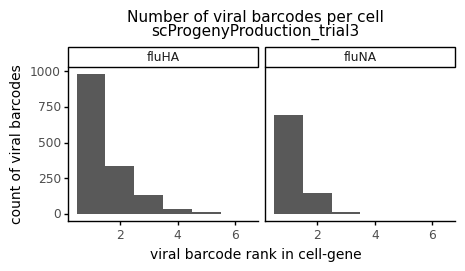

<ggplot: (8765622400031)>

In [38]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='viral_bc_rank'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('viral barcode rank in cell-gene') +
       p9.ylab('count of viral barcodes') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 29349 rows containing missing values.


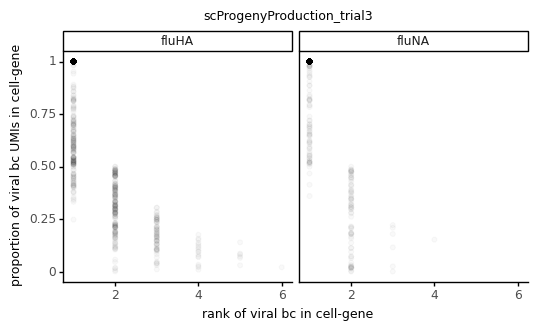

<ggplot: (8766305420541)>

In [39]:
fig = (p9.ggplot((viral_bc_freqs),
                 p9.aes(x='viral_bc_rank',
                        y='prop_cell_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.01) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='rank of viral bc in cell-gene',
               y='proportion of viral bc UMIs in cell-gene') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
      p9.scale_color_discrete(guide=False))
display(fig)

**Sanity check: viral rank vs number of viral barcodes per cell.**

The `n_significant_viral_bc_per_cell` histogram and `significant_viral_bc_rank_per_cell` histgoram do not look identical. I think some significant viral barcodes may be assigned duplicate ranks. I should check this and make sure it makes sense.

Result: Yes, sometimes low frequency viral barcodes in a cell have the same number of UMIs and get assigned identical ranks.

In [40]:
viral_bc_freqs.query('n_viral_bc > 3')

cell_barcode  infected infecting_viral_tag  frac_viral_UMIs   gene  \
7865   ACAGAAATCTCTTGCG  infected                  wt         0.062168  fluHA   
7866   ACAGAAATCTCTTGCG  infected                  wt         0.062168  fluHA   
7868   ACAGAAATCTCTTGCG  infected                  wt         0.062168  fluHA   
7870   ACAGAAATCTCTTGCG  infected                  wt         0.062168  fluHA   
7871   ACAGAAATCTCTTGCG  infected                  wt         0.062168  fluHA   
...                 ...       ...                 ...              ...    ...   
20736  TGTTCCGTCACGGACC  infected                  wt         0.072452  fluHA   
20738  TGTTCCGTCACGGACC  infected                  wt         0.072452  fluNA   
20740  TGTTCCGTCACGGACC  infected                  wt         0.072452  fluNA   
20741  TGTTCCGTCACGGACC  infected                  wt         0.072452  fluNA   
20743  TGTTCCGTCACGGACC  infected                  wt         0.072452  fluNA   

          viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs reject_uninfected  \
7865   AAATATGAAACGATTT          176.0            0.001882              True   
7866   AACTATCGGAGTAACA          234.0            0.002503              True   
7868   GACCTTCTGAGAAAAC           51.0            0.000545              True   
7870   GTGAGACGTGACTTTC           47.0            0.000503              True   
7871   GTTTCTTCTTTTTTAG          195.0            0.002085              True   
...                 ...            ...                 ...               ...   
20736  TGTGTCTTAATACTAT           63.0            0.000500              True   
20738  AGATCTGTGTTGTGAT           17.0            0.000135              True   
20740  GTATCATTTAGTCGGA           20.0            0.000159              True   
20741  GTATCTTAAGTGTGAT           34.0            0.000270              True   
20743  TTGCTAGGTTTCTGTG           40.0            0.000317              True   

                 source  ...  freq_progeny  total_UMIs  viral_UMIs  n_cell_bc  \
7865        supernatant  ...      0.000000     93505.0      5813.0        1.0   
7866        supernatant  ...      0.000000     93505.0      5813.0        1.0   
7868        supernatant  ...      0.002546     93505.0      5813.0        1.0   
7870        supernatant  ...      0.000527     93505.0      5813.0        1.0   
7871        supernatant  ...      0.000000     93505.0      5813.0        1.0   
...                 ...  ...           ...         ...         ...        ...   
20736  second_infection  ...      0.000000    126029.0      9131.0        1.0   
20738  second_infection  ...      0.000000    126029.0      9131.0        1.0   
20740  second_infection  ...      0.000000    126029.0      9131.0        1.0   
20741  second_infection  ...      0.006342    126029.0      9131.0        1.0   
20743  second_infection  ...      0.000012    126029.0      9131.0        1.0   

       gt1_cell  n_viral_bc  coinfected  cell_total_frac_viral_bc_UMIs  \
7865      False         5.0        True                       0.007518   
7866      False         5.0        True                       0.007518   
7868      False         5.0        True                       0.007518   
7870      False         5.0        True                       0.007518   
7871      False         5.0        True                       0.007518   
...         ...         ...         ...                            ...   
20736     False         4.0        True                       0.003618   
20738     False         4.0        True                       0.000881   
20740     False         4.0        True                       0.000881   
20741     False         4.0        True                       0.000881   
20743     False         4.0        True                       0.000881   

       prop_cell_viral_bc_UMIs  viral_bc_rank  
7865                  0.250356            3.0  
7866                  0.332859            1.0  
7868                  0.072546            4.0  
7870                  0

#### Annotate most abundant viral barcode for each cell-gene:

In [41]:
viral_bc_freqs['top_viral_bc'] = (viral_bc_freqs['viral_bc_rank'] == 1)
viral_bc_freqs['top_viral_bc'].value_counts()

False    30025
True      1676
Name: top_viral_bc, dtype: int64

#### Plot with most abundant viral barcode annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


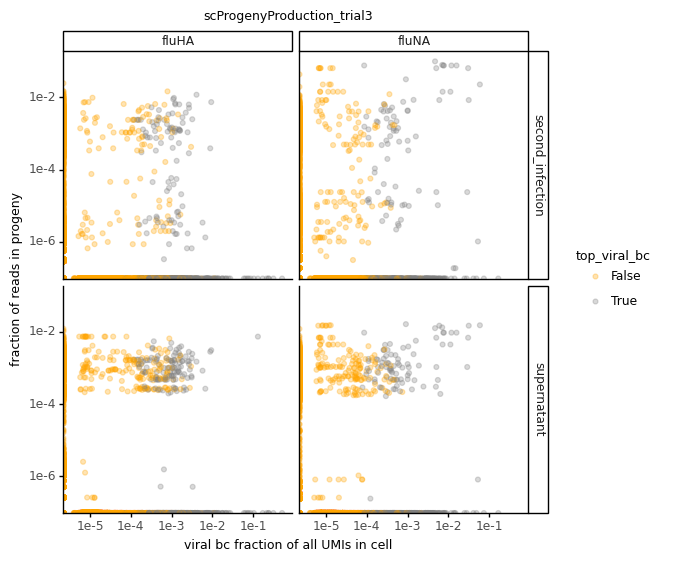

<ggplot: (8765622476210)>

In [42]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='top_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral bc fraction of all UMIs in cell',
               y='fraction of reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

#### Viral burden
Plot the viral burden (total fraction of viral UMIs in cell) against the supernatant frequency of the most abundant viral barcode for that cell.

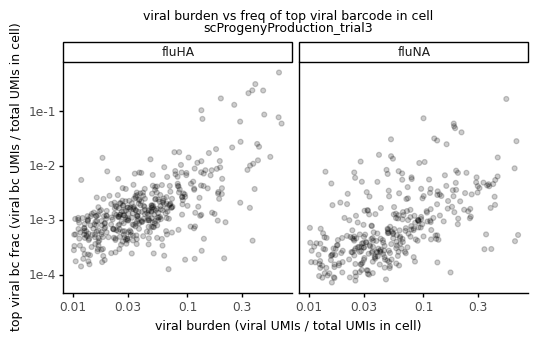

<ggplot: (8765619426169)>

In [43]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == "infected") and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle('viral burden vs freq of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell)',
               y='top viral bc frac (viral bc UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

**Total UMIs per cell**

Plot the frequency of the top viral barcode as a function of total UMIs in a cell

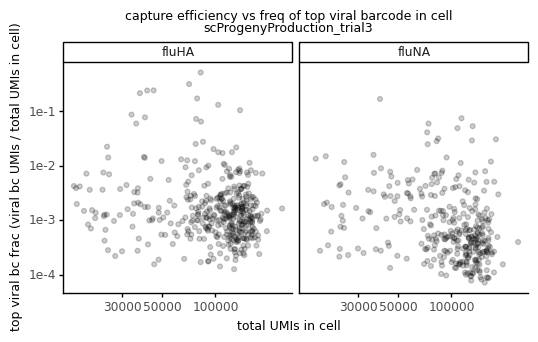

<ggplot: (8765606231290)>

In [44]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(infected == "infected") and'
                        '(top_viral_bc == True)'),
                 p9.aes(x='total_UMIs',
                        y='frac_viral_bc_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle('capture efficiency vs freq of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='total UMIs in cell',
               y='top viral bc frac (viral bc UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot only the top viral barcode for each cell-gene:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


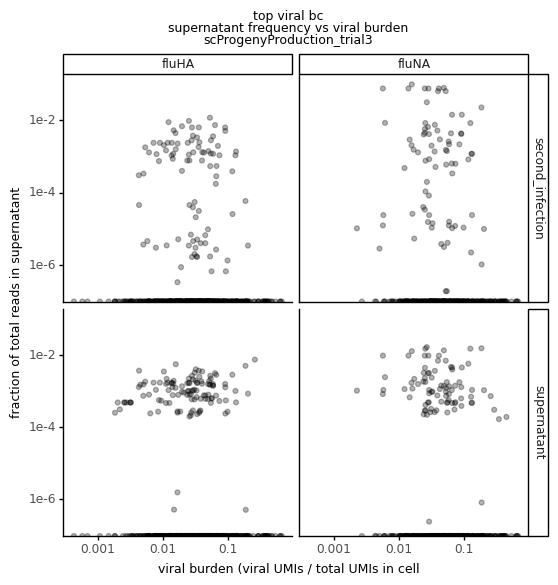

<ggplot: (8766305553677)>

In [45]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'top viral bc\n'
                   'supernatant frequency vs viral burden\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

#### Correlation of fluHA and fluNA top viral barcodes in each cell
Check to see if cells associated with high fluHA also produce high fluNA values. 

First, pivot table so supernatant frequency of top fluHA viral barcode and top fluNA viral barcode are put in column alongside cell barcode. Fill NA values with zero because this means it was not observed in sequencing, so the frequency is meaningfully zero.

**Viral barcode transcription:**

In [46]:
high_transcription = (pd.pivot_table(
    viral_bc_freqs
    .query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag'],
    values='frac_viral_bc_UMIs',
    columns='gene')
                .reset_index()
                .fillna(0))

high_transcription

gene      cell_barcode   infected infecting_viral_tag     fluHA     fluNA
0     AAACGAAGTACTTCCC   infected                both  0.000000  0.005473
1     AAACGAAGTAGACGTG   infected                  wt  0.002019  0.000209
2     AAAGGATTCTGATGGT   infected                 syn  0.001424  0.007085
3     AAAGGGCCAGGCTACC   infected                  wt  0.001532  0.000346
4     AAAGGGCTCCGCACTT   infected                  wt  0.000257  0.000000
..                 ...        ...                 ...       ...       ...
540   TTTAGTCGTGCTCCGA   infected                  wt  0.001501  0.000000
541   TTTCACAAGCCAAGCA   infected                  wt  0.004472  0.002718
542   TTTCGATTCAATCCAG  ambiguous                  wt  0.000704  0.000000
543   TTTGATCTCGCATTGA   infected                  wt  0.002124  0.000000
544   TTTGGAGGTATCGTTG   infected                  wt  0.000433  0.000260

[545 rows x 5 columns]

Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


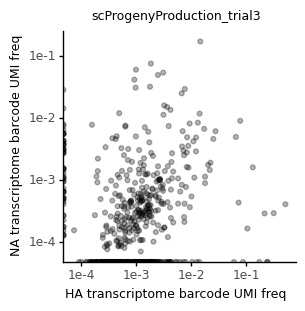

<ggplot: (8765622011158)>

In [47]:
fig = (p9.ggplot(high_transcription,
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA transcriptome barcode UMI freq',
               y='NA transcriptome barcode UMI freq') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

**Supernatant progeny production:**

In [48]:
high_progeny = (pd.pivot_table(
    viral_bc_freqs.query('top_viral_bc == True '),
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag',
           'source'],
    values='freq_progeny',
    columns='gene')
                .reset_index()
                .fillna(0))

high_progeny

gene      cell_barcode   infected infecting_viral_tag            source  \
0     AAACGAAGTACTTCCC   infected                both  second_infection   
1     AAACGAAGTACTTCCC   infected                both       supernatant   
2     AAACGAAGTAGACGTG   infected                  wt  second_infection   
3     AAACGAAGTAGACGTG   infected                  wt       supernatant   
4     AAAGGATTCTGATGGT   infected                 syn  second_infection   
...                ...        ...                 ...               ...   
1085  TTTCGATTCAATCCAG  ambiguous                  wt       supernatant   
1086  TTTGATCTCGCATTGA   infected                  wt  second_infection   
1087  TTTGATCTCGCATTGA   infected                  wt       supernatant   
1088  TTTGGAGGTATCGTTG   infected                  wt  second_infection   
1089  TTTGGAGGTATCGTTG   infected                  wt       supernatant   

gene     fluHA     fluNA  
0     0.000000  0.000000  
1     0.000000  0.000000  
2     0.000000  0.000000  
3     0.000287  0.000291  
4     0.000000  0.078876  
...        ...       ...  
1085  0.000536  0.000000  
1086  0.000000  0.000000  
1087  0.000000  0.000000  
1088  0.000000  0.000040  
1089  0.000774  0.001808  

[1090 rows x 6 columns]

Plot correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


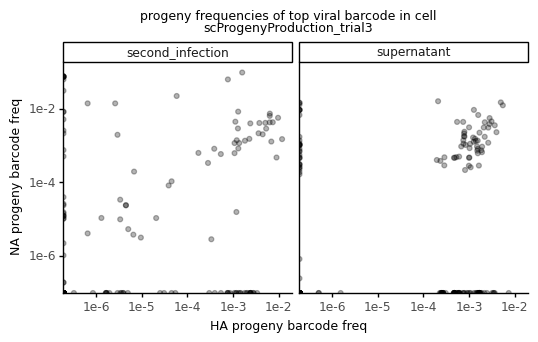

<ggplot: (8765619459133)>

In [49]:
fig = (p9.ggplot(high_progeny.
                 fillna(0),
                 p9.aes(x='fluHA',
                        y='fluNA')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~source') +
       p9.ggtitle('progeny frequencies of top viral barcode in cell\n'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='HA progeny barcode freq',
               y='NA progeny barcode freq') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

In [50]:
high_progeny['progeny_freq'] = high_progeny[['fluHA', 'fluNA']].max(axis=1)

display(high_progeny)

gene      cell_barcode   infected infecting_viral_tag            source  \
0     AAACGAAGTACTTCCC   infected                both  second_infection   
1     AAACGAAGTACTTCCC   infected                both       supernatant   
2     AAACGAAGTAGACGTG   infected                  wt  second_infection   
3     AAACGAAGTAGACGTG   infected                  wt       supernatant   
4     AAAGGATTCTGATGGT   infected                 syn  second_infection   
...                ...        ...                 ...               ...   
1085  TTTCGATTCAATCCAG  ambiguous                  wt       supernatant   
1086  TTTGATCTCGCATTGA   infected                  wt  second_infection   
1087  TTTGATCTCGCATTGA   infected                  wt       supernatant   
1088  TTTGGAGGTATCGTTG   infected                  wt  second_infection   
1089  TTTGGAGGTATCGTTG   infected                  wt       supernatant   

gene     fluHA     fluNA  progeny_freq  
0     0.000000  0.000000      0.000000  
1     0.000000  0.000000      0.000000  
2     0.000000  0.000000      0.000000  
3     0.000287  0.000291      0.000291  
4     0.000000  0.078876      0.078876  
...        ...       ...           ...  
1085  0.000536  0.000000      0.000536  
1086  0.000000  0.000000      0.000000  
1087  0.000000  0.000000      0.000000  
1088  0.000000  0.000040      0.000040  
1089  0.000774  0.001808      0.001808  

[1090 rows x 7 columns]

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 821 rows containing non-finite values.


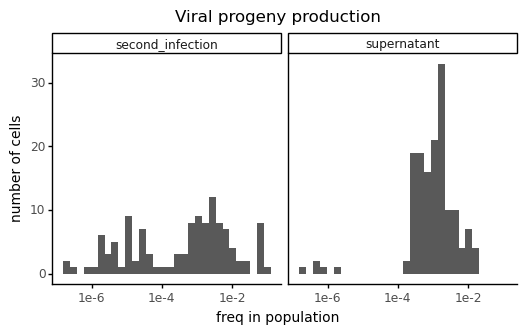

<ggplot: (8766305731325)>

In [51]:
fig = (p9.ggplot((high_progeny),
                 p9.aes(x='progeny_freq')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~source') +
       p9.ggtitle(f'Viral progeny production') +
       p9.labs(x='freq in population',
               y='number of cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


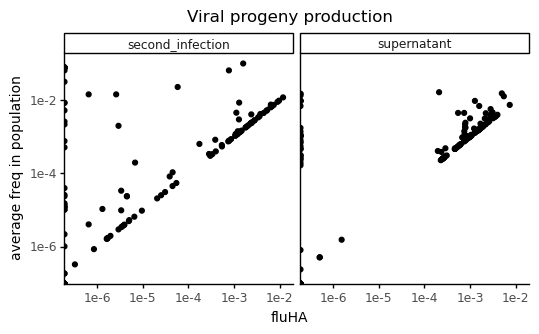

<ggplot: (8766305651044)>

In [52]:
fig = (p9.ggplot((high_progeny),
                 p9.aes(x='fluHA',
                        y='progeny_freq')) +
       p9.geom_point() +
       p9.facet_grid('~source') +
       p9.ggtitle(f'Viral progeny production') +
       p9.labs(y='average freq in population',
               x='fluHA') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


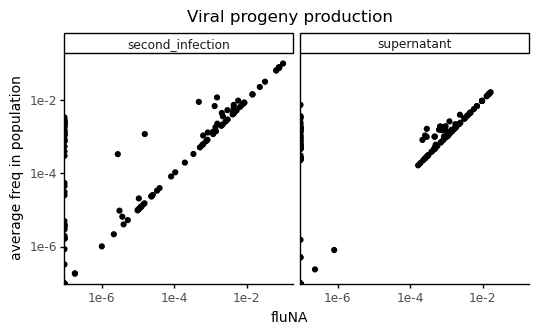

<ggplot: (8765619667577)>

In [53]:
fig = (p9.ggplot((high_progeny),
                 p9.aes(x='fluNA',
                        y='progeny_freq')) +
       p9.geom_point() +
       p9.facet_grid('~source') +
       p9.ggtitle(f'Viral progeny production') +
       p9.labs(y='average freq in population',
               x='fluNA') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

## Viral gene expression

#### Viral genes in each cell
Extract the UMI counts for each viral gene in each cell from `adata.obs`

In [54]:
#### Viral genes in each cell
viral_gene_expression = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                   .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            fluPB2=numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ]
                             .X, axis=0).A1.astype(int),
            fluPB1=numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ]
                             .X, axis=0).A1.astype(int),
            fluPA=numpy.sum(adata[adata.obs['gene'] == 'fluPA', ]
                             .X, axis=0).A1.astype(int),
            fluHA=numpy.sum(adata[adata.obs['gene'] == 'fluHA', ]
                             .X, axis=0).A1.astype(int),
            fluNP=numpy.sum(adata[adata.obs['gene'] == 'fluNP', ]
                             .X, axis=0).A1.astype(int),
            fluNA=numpy.sum(adata[adata.obs['gene'] == 'fluNA', ]
                             .X, axis=0).A1.astype(int),
            fluM=numpy.sum(adata[adata.obs['gene'] == 'fluM', ]
                             .X, axis=0).A1.astype(int),
            fluNS=numpy.sum(adata[adata.obs['gene'] == 'fluNS', ]
                             .X, axis=0).A1.astype(int),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


cell_barcode  total_UMIs  viral_UMIs  fluPB2  fluPB1  fluPA  fluHA  \
0     AAACCCAGTAACAAGT       47873           6       0       0      0      2   
1     AAACCCATCATTGCTT       90114          10       1       0      0      0   
2     AAACGAAAGATGTTGA      111630          18       0       0      0      3   
3     AAACGAAGTACTTCCC       56828       24082     160     506     23      2   
4     AAACGAAGTAGACGTG      124341        4654       3      45     11    319   
...                ...         ...         ...     ...     ...    ...    ...   
3367  TTTGATCTCCCGTTCA       63150           3       0       0      0      0   
3368  TTTGATCTCGCATTGA      170914       10415      30      85     15    616   
3369  TTTGGAGAGTTGCCTA       65941          12       0       0      0      0   
3370  TTTGGAGGTATCGTTG      150130        3526       8      57      7     93   
3371  TTTGTTGAGTGCAGCA      135009           8       0       0      0      2   

      fluNP  fluNA   fluM  fluNS  
0         0      0      3      1  
1         3      0      5      1  
2         1      0     10      4  
3      4139    420  13060   5772  
4       608     31   1582   2055  
...     ...    ...    ...    ...  
3367      1      0      1      1  
3368   1237   1344   4841   2247  
3369      1      1      6      4  
3370    418     45   1668   1230  
3371      0      1      2      3  

[3372 rows x 11 columns]

Bring in infection status and tag information:

In [55]:
viral_gene_expression = pd.merge(
    left=viral_gene_expression,
    right=(viral_bc_freqs
           .query('cell_barcode.notnull()',
                  engine='python')
           [['cell_barcode',
             'infected',
             'infecting_viral_tag']]
           .drop_duplicates()),
    on='cell_barcode',
    how='left',
    validate='one_to_one'
    )

viral_gene_expression

cell_barcode  total_UMIs  viral_UMIs  fluPB2  fluPB1  fluPA  fluHA  \
0     AAACCCAGTAACAAGT       47873           6       0       0      0      2   
1     AAACCCATCATTGCTT       90114          10       1       0      0      0   
2     AAACGAAAGATGTTGA      111630          18       0       0      0      3   
3     AAACGAAGTACTTCCC       56828       24082     160     506     23      2   
4     AAACGAAGTAGACGTG      124341        4654       3      45     11    319   
...                ...         ...         ...     ...     ...    ...    ...   
3367  TTTGATCTCCCGTTCA       63150           3       0       0      0      0   
3368  TTTGATCTCGCATTGA      170914       10415      30      85     15    616   
3369  TTTGGAGAGTTGCCTA       65941          12       0       0      0      0   
3370  TTTGGAGGTATCGTTG      150130        3526       8      57      7     93   
3371  TTTGTTGAGTGCAGCA      135009           8       0       0      0      2   

      fluNP  fluNA   fluM  fluNS    infected infecting_viral_tag  
0         0      0      3      1  uninfected                none  
1         3      0      5      1  uninfected                none  
2         1      0     10      4  uninfected                none  
3      4139    420  13060   5772    infected                both  
4       608     31   1582   2055    infected                  wt  
...     ...    ...    ...    ...         ...                 ...  
3367      1      0      1      1  uninfected                none  
3368   1237   1344   4841   2247    infected                  wt  
3369      1      1      6      4  uninfected                none  
3370    418     45   1668   1230    infected                  wt  
3371      0      1      2      3  uninfected                none  

[3372 rows x 13 columns]

Pivot the table so that gene is a column, and the UMI counts for each gene for each cell is a row

In [56]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

viral_gene_expression_long

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none       47873   
1      AAACCCATCATTGCTT  uninfected                none       90114   
2      AAACGAAAGATGTTGA  uninfected                none      111630   
3      AAACGAAGTACTTCCC    infected                both       56828   
4      AAACGAAGTAGACGTG    infected                  wt      124341   
...                 ...         ...                 ...         ...   
26971  TTTGATCTCCCGTTCA  uninfected                none       63150   
26972  TTTGATCTCGCATTGA    infected                  wt      170914   
26973  TTTGGAGAGTTGCCTA  uninfected                none       65941   
26974  TTTGGAGGTATCGTTG    infected                  wt      150130   
26975  TTTGTTGAGTGCAGCA  uninfected                none      135009   

       viral_UMIs    gene  gene_UMIs  
0               6  fluPB2          0  
1              10  fluPB2          1  
2              18  fluPB2          0  
3           24082  fluPB2        160  
4            4654  fluPB2          3  
...           ...     ...        ...  
26971           3   fluNS          1  
26972       10415   fluNS       2247  
26973          12   fluNS          4  
26974        3526   fluNS       1230  
26975           8   fluNS          3  

[26976 rows x 7 columns]

Check that total number of rows is = total number of cells * total number of genes, for both infected and uninfected:

In [57]:
assert (len(viral_gene_expression_long) ==
        len(viral_gene_expression_long['cell_barcode'].drop_duplicates()) *
        len(viral_genes)), "not 8 genes for every cell"

Check that the extracted gene_UMIs sum to the total viral UMIs for each cell:

In [58]:
pd.testing.assert_frame_equal(
    (viral_gene_expression_long[['cell_barcode',
                                 'viral_UMIs']]
     .drop_duplicates()),
    (viral_gene_expression_long
     .groupby('cell_barcode')
     ['gene_UMIs']
     .sum()
     .to_frame()
     .reset_index()
     .rename(columns={'gene_UMIs': 'viral_UMIs'})),
    check_names=False,
    check_index_type=False
)

Calculate the fraction of all UMIs assigned to each viral gene individually, and in aggregate:

In [59]:
viral_gene_expression_long['frac_viral_UMIs'] = (
    viral_gene_expression_long['viral_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long['frac_gene_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none       47873   
1      AAACCCATCATTGCTT  uninfected                none       90114   
2      AAACGAAAGATGTTGA  uninfected                none      111630   
3      AAACGAAGTACTTCCC    infected                both       56828   
4      AAACGAAGTAGACGTG    infected                  wt      124341   
...                 ...         ...                 ...         ...   
26971  TTTGATCTCCCGTTCA  uninfected                none       63150   
26972  TTTGATCTCGCATTGA    infected                  wt      170914   
26973  TTTGGAGAGTTGCCTA  uninfected                none       65941   
26974  TTTGGAGGTATCGTTG    infected                  wt      150130   
26975  TTTGTTGAGTGCAGCA  uninfected                none      135009   

       viral_UMIs    gene  gene_UMIs  frac_viral_UMIs  frac_gene_UMIs  
0               6  fluPB2          0         0.000125        0.000000  
1              10  fluPB2          1         0.000111        0.000011  
2              18  fluPB2          0         0.000161        0.000000  
3           24082  fluPB2        160         0.423770        0.002816  
4            4654  fluPB2          3         0.037429        0.000024  
...           ...     ...        ...              ...             ...  
26971           3   fluNS          1         0.000048        0.000016  
26972       10415   fluNS       2247         0.060937        0.013147  
26973          12   fluNS          4         0.000182        0.000061  
26974        3526   fluNS       1230         0.023486        0.008193  
26975           8   fluNS          3         0.000059        0.000022  

[26976 rows x 9 columns]

Plot distribution of absolute UMI counts for each gene:

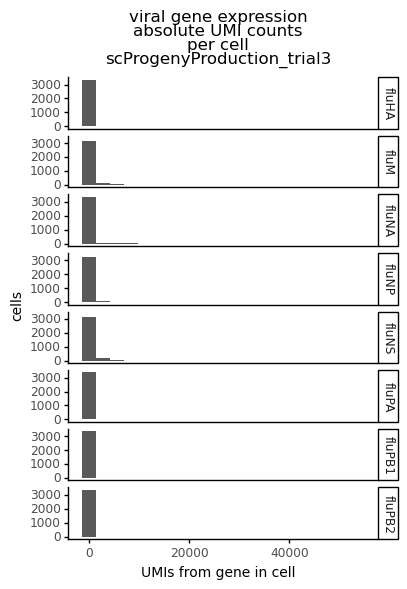

<ggplot: (8765619468566)>

In [60]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 11443 rows containing non-finite values.


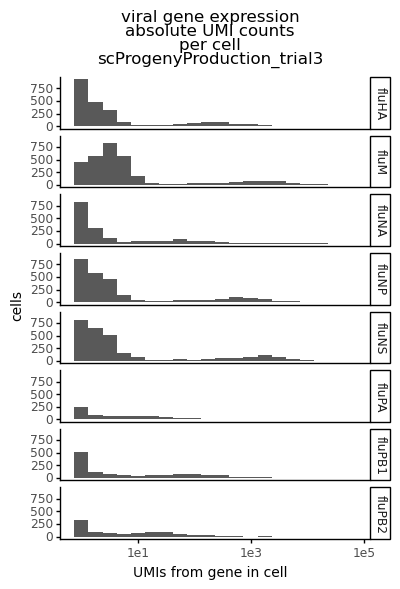

<ggplot: (8765619850250)>

In [61]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot distribution of fraction of UMIs from each viral gene:

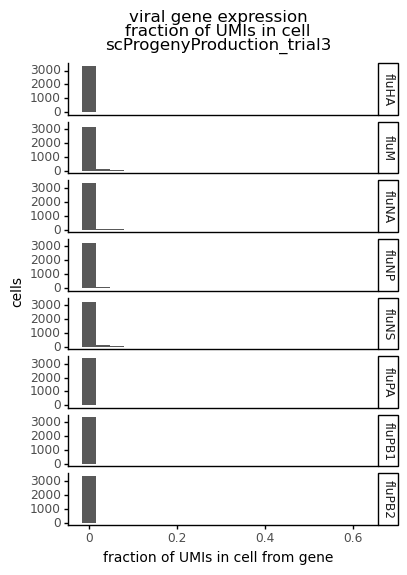

<ggplot: (8766305397245)>

In [62]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 11443 rows containing non-finite values.


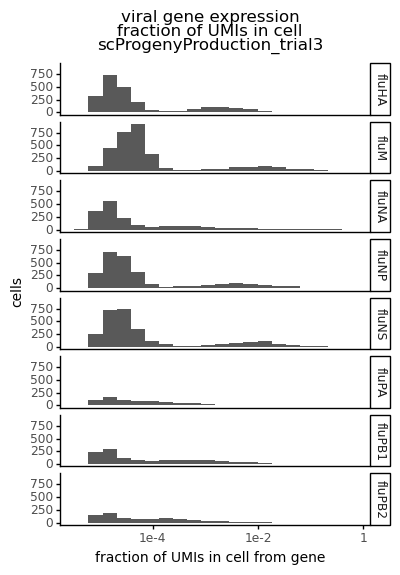

<ggplot: (8765619556624)>

In [63]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

What is the relationship between absolute UMI counts and fraction of all UMIs in cell for each gene?

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


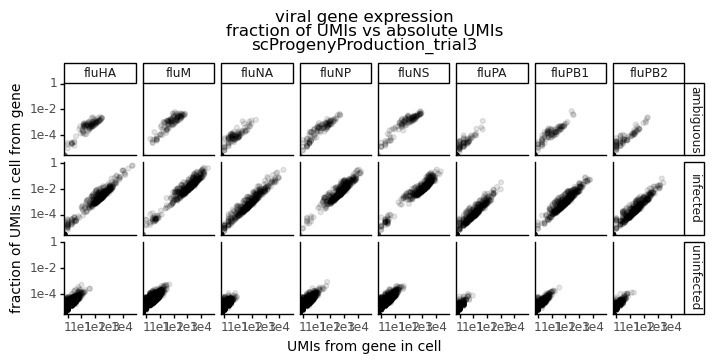

<ggplot: (8765619436951)>

In [64]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs',
                        y='frac_gene_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs vs absolute UMIs\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='fraction of UMIs in cell from gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(8, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Distribution of viral gene expression in infected and **uninfected** cells:

**N.b.** Plot 0 values on far left of axis, 100-fold lower than lowest real value:

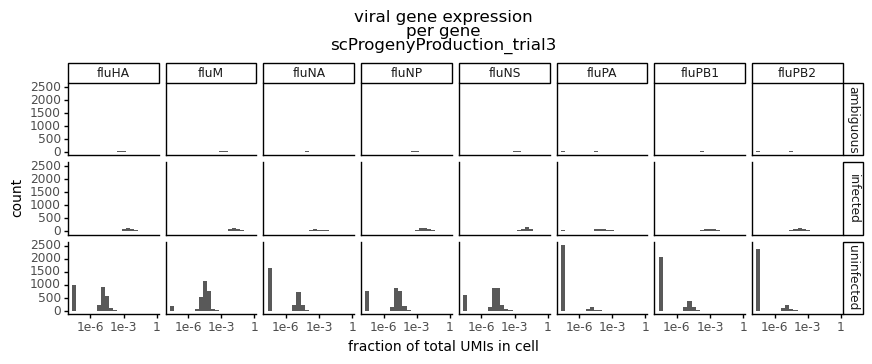

<ggplot: (8765622026981)>

In [65]:
zero_pseudocount = (min(viral_gene_expression_long
                        .query('frac_gene_UMIs > 0')
                        ['frac_gene_UMIs']) /
                    100)
zero_pseudocount

fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 11443 rows containing non-finite values.


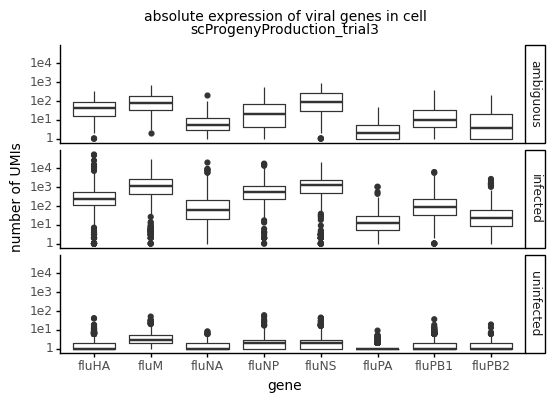

<ggplot: (8765620297108)>

In [66]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('absolute expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of UMIs') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 11443 rows containing non-finite values.


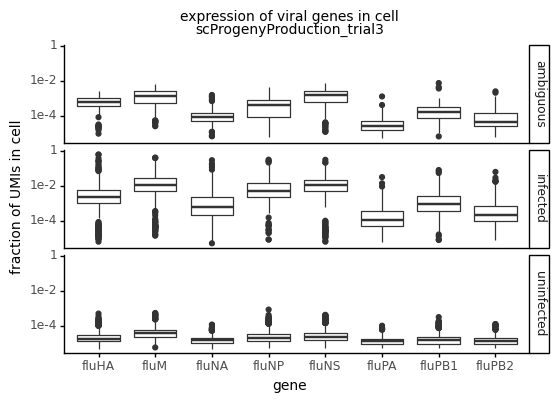

<ggplot: (8765622442701)>

In [67]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='frac_gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('fraction of UMIs in cell') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

#### Proportion of viral UMIs from each gene

Next, within each cell, I will calculate the proportion of all viral UMIs derived from each gene. 

In [68]:
viral_gene_expression_long['prop_viral_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['viral_UMIs']
)

viral_gene_expression_long

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none       47873   
1      AAACCCATCATTGCTT  uninfected                none       90114   
2      AAACGAAAGATGTTGA  uninfected                none      111630   
3      AAACGAAGTACTTCCC    infected                both       56828   
4      AAACGAAGTAGACGTG    infected                  wt      124341   
...                 ...         ...                 ...         ...   
26971  TTTGATCTCCCGTTCA  uninfected                none       63150   
26972  TTTGATCTCGCATTGA    infected                  wt      170914   
26973  TTTGGAGAGTTGCCTA  uninfected                none       65941   
26974  TTTGGAGGTATCGTTG    infected                  wt      150130   
26975  TTTGTTGAGTGCAGCA  uninfected                none      135009   

       viral_UMIs    gene  gene_UMIs  frac_viral_UMIs  frac_gene_UMIs  \
0               6  fluPB2          0         0.000125        0.000000   
1              10  fluPB2          1         0.000111        0.000011   
2              18  fluPB2          0         0.000161        0.000000   
3           24082  fluPB2        160         0.423770        0.002816   
4            4654  fluPB2          3         0.037429        0.000024   
...           ...     ...        ...              ...             ...   
26971           3   fluNS          1         0.000048        0.000016   
26972       10415   fluNS       2247         0.060937        0.013147   
26973          12   fluNS          4         0.000182        0.000061   
26974        3526   fluNS       1230         0.023486        0.008193   
26975           8   fluNS          3         0.000059        0.000022   

       prop_viral_UMIs  
0             0.000000  
1             0.100000  
2             0.000000  
3             0.006644  
4             0.000645  
...                ...  
26971         0.333333  
26972         0.215747  
26973         0.333333  
26974         0.348837  
26975         0.375000  

[26976 rows x 10 columns]

Check that the proportion sums to 1 for every cell:

In [69]:
test_prop_sum_df = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_gene_expression_long
           .groupby('cell_barcode')
           ['prop_viral_UMIs']
           .sum()
           .round(4)),
    suffixes=[None,'_sum'],
    on='cell_barcode',
)

test_prop_sum_df['sum_OK'] = test_prop_sum_df.apply(
    lambda x: (x['prop_viral_UMIs_sum'] == 1) or (x['viral_UMIs'] == 0),
    axis=1)
                              
assert (test_prop_sum_df['sum_OK'] == True).all(), \
    "problem summing viral gene proportions"

test_prop_sum_df


cell_barcode    infected infecting_viral_tag  total_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none       47873   
1      AAACCCAGTAACAAGT  uninfected                none       47873   
2      AAACCCAGTAACAAGT  uninfected                none       47873   
3      AAACCCAGTAACAAGT  uninfected                none       47873   
4      AAACCCAGTAACAAGT  uninfected                none       47873   
...                 ...         ...                 ...         ...   
26971  TTTGTTGAGTGCAGCA  uninfected                none      135009   
26972  TTTGTTGAGTGCAGCA  uninfected                none      135009   
26973  TTTGTTGAGTGCAGCA  uninfected                none      135009   
26974  TTTGTTGAGTGCAGCA  uninfected                none      135009   
26975  TTTGTTGAGTGCAGCA  uninfected                none      135009   

       viral_UMIs    gene  gene_UMIs  frac_viral_UMIs  frac_gene_UMIs  \
0               6  fluPB2          0         0.000125        0.000000   
1               6  fluPB1          0         0.000125        0.000000   
2               6   fluPA          0         0.000125        0.000000   
3               6   fluHA          2         0.000125        0.000042   
4               6   fluNP          0         0.000125        0.000000   
...           ...     ...        ...              ...             ...   
26971           8   fluHA          2         0.000059        0.000015   
26972           8   fluNP          0         0.000059        0.000000   
26973           8   fluNA          1         0.000059        0.000007   
26974           8    fluM          2         0.000059        0.000015   
26975           8   fluNS          3         0.000059        0.000022   

       prop_viral_UMIs  prop_viral_UMIs_sum  sum_OK  
0             0.000000                  1.0    True  
1             0.000000                  1.0    True  
2             0.000000                  1.0    True  
3             0.333333                  1.0    True  
4             0.000000                  1.0    True  
...                ...                  ...     ...  
26971         0.250000                  1.0    True  
26972         0.000000                  1.0    True  
26973         0.125000                  1.0    True  
26974         0.250000                  1.0    True  
26975         0.375000                  1.0    True  

[26976 rows x 12 columns]

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 104 rows containing non-finite values.


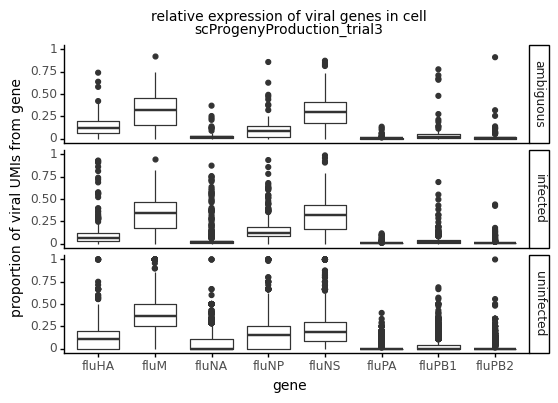

<ggplot: (8765619319357)>

In [70]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='prop_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('relative expression of viral genes in cell\n'
                         f'{expt}') +
              p9.facet_grid('infected~') +
              p9.xlab('gene') +
              p9.ylab('proportion of viral UMIs from gene') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

### Call presence/absence of viral genes

Next I will extract the 90 percentile value from the uninfected cells. We were very conservative in calling cells as infected (likely there are some infected cells in the population labelled "uninfected"). A priori, we expect most infected cells to express most viral genes. So we can be more lenient in what we use as a cutoff in calling a gene present.

For low expressing genes (e.g. the polymerase complex), the 95th percentile is a value of 0, and this threshold does not work well. Instead, we will simply call genes without **any** UMIs as absent, and genes with at least 1 UMI as present.  In some previous analyses (e.g. [Russel et al. 2018](https://elifesciences.org/articles/32303)) a single transcript was used to call the presence of a gene in infected cells.

In [71]:
limit_percentile = 0.9
limit = dict()

for gene in viral_genes:
    limit[gene] = (viral_gene_expression_long
                   .query('(infecting_viral_tag == "none") '
                          f'and (gene == "{gene}")')
                   ['frac_gene_UMIs']
                   .quantile(limit_percentile))

limit = pd.DataFrame.from_dict(limit, orient='index')
limit = limit.reset_index()
limit = limit.rename(columns={0: 'limit_frac',
                              'index': 'gene'})

limit

gene  limit_frac
0  fluPB2    0.000010
1  fluPB1    0.000017
2   fluPA    0.000000
3   fluHA    0.000037
4   fluNA    0.000020
5   fluNP    0.000045
6    fluM    0.000083
7   fluNS    0.000053

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 11443 rows containing non-finite values.


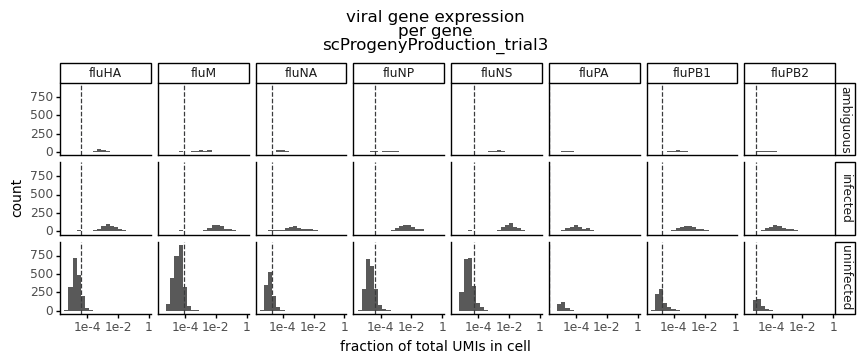

<ggplot: (8766305504732)>

In [72]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.geom_vline(limit,
                     p9.aes(xintercept='limit_frac'),
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

Build a poisson distribution around this value. I will perform a statistical test to see if the value seen for each gene in infected cells falls within this distribution or rejects the null hypothesis.

Now calculate the expected number of UMIs for each gene using this upper bound limit. For every cell and gene, I will simply multiply the total number of UMIs by this limit value.

In [73]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=limit,
    on=['gene'],
    how='left'
    )

Calculate the expected number of UMIs corresponding to this limit fraction for each cell.

In [74]:
viral_gene_expression_long['limit_UMIs'] = (viral_gene_expression_long['total_UMIs'] *
                                            viral_gene_expression_long['limit_frac'])
viral_gene_expression_long

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none       47873   
1      AAACCCATCATTGCTT  uninfected                none       90114   
2      AAACGAAAGATGTTGA  uninfected                none      111630   
3      AAACGAAGTACTTCCC    infected                both       56828   
4      AAACGAAGTAGACGTG    infected                  wt      124341   
...                 ...         ...                 ...         ...   
26971  TTTGATCTCCCGTTCA  uninfected                none       63150   
26972  TTTGATCTCGCATTGA    infected                  wt      170914   
26973  TTTGGAGAGTTGCCTA  uninfected                none       65941   
26974  TTTGGAGGTATCGTTG    infected                  wt      150130   
26975  TTTGTTGAGTGCAGCA  uninfected                none      135009   

       viral_UMIs    gene  gene_UMIs  frac_viral_UMIs  frac_gene_UMIs  \
0               6  fluPB2          0         0.000125        0.000000   
1              10  fluPB2          1         0.000111        0.000011   
2              18  fluPB2          0         0.000161        0.000000   
3           24082  fluPB2        160         0.423770        0.002816   
4            4654  fluPB2          3         0.037429        0.000024   
...           ...     ...        ...              ...             ...   
26971           3   fluNS          1         0.000048        0.000016   
26972       10415   fluNS       2247         0.060937        0.013147   
26973          12   fluNS          4         0.000182        0.000061   
26974        3526   fluNS       1230         0.023486        0.008193   
26975           8   fluNS          3         0.000059        0.000022   

       prop_viral_UMIs  limit_frac  limit_UMIs  
0             0.000000    0.000010    0.467492  
1             0.100000    0.000010    0.879985  
2             0.000000    0.000010    1.090094  
3             0.006644    0.000010    0.554939  
4             0.000645    0.000010    1.214220  
...                ...         ...         ...  
26971         0.333333    0.000053    3.337687  
26972         0.215747    0.000053    9.033373  
26973         0.333333    0.000053    3.485201  
26974         0.348837    0.000053    7.934870  
26975         0.375000    0.000053    7.135674  

[26976 rows x 12 columns]

Calculate the p-value that a gene is present above the background distribution (poisson distribution with mu = `limit_UMIs`).

A few notes on how this is calculated:  
* We want the probability of yielding greater than **or equal to** the observed number of UMIs for each gene.
* `P = scipy.stats.poisson.cdf(k = x, mu = l)` returns the probability of yielding less than or equal to the observed number of UMIs (`x`) for each gene.
* To get the probability of yielding **greater than** `x`, we simply take `1 - P`.
* Because the Poisson distribution functions on integers, to get the probability of yielding a value greater than **or equal to**, we simply calcuate P on `x - 1`.

The final expression to return the **probability of yielding greater than or equal to the observed number of UMIs** is:  
`P = 1 - scipy.stats.poisson.cdf(k = (x-1), mu = l)`

In [75]:
p_cutoff = 0.05

viral_gene_expression_long['null_P'] = (
    1 - scipy.stats.poisson.cdf(
        k=(viral_gene_expression_long['gene_UMIs']-1),
        mu=viral_gene_expression_long['limit_UMIs']))

viral_gene_expression_long['gene_present'] = (
    (viral_gene_expression_long['gene_UMIs'] > 0)
    & (viral_gene_expression_long['null_P'] < p_cutoff))

viral_gene_expression_long

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none       47873   
1      AAACCCATCATTGCTT  uninfected                none       90114   
2      AAACGAAAGATGTTGA  uninfected                none      111630   
3      AAACGAAGTACTTCCC    infected                both       56828   
4      AAACGAAGTAGACGTG    infected                  wt      124341   
...                 ...         ...                 ...         ...   
26971  TTTGATCTCCCGTTCA  uninfected                none       63150   
26972  TTTGATCTCGCATTGA    infected                  wt      170914   
26973  TTTGGAGAGTTGCCTA  uninfected                none       65941   
26974  TTTGGAGGTATCGTTG    infected                  wt      150130   
26975  TTTGTTGAGTGCAGCA  uninfected                none      135009   

       viral_UMIs    gene  gene_UMIs  frac_viral_UMIs  frac_gene_UMIs  \
0               6  fluPB2          0         0.000125        0.000000   
1              10  fluPB2          1         0.000111        0.000011   
2              18  fluPB2          0         0.000161        0.000000   
3           24082  fluPB2        160         0.423770        0.002816   
4            4654  fluPB2          3         0.037429        0.000024   
...           ...     ...        ...              ...             ...   
26971           3   fluNS          1         0.000048        0.000016   
26972       10415   fluNS       2247         0.060937        0.013147   
26973          12   fluNS          4         0.000182        0.000061   
26974        3526   fluNS       1230         0.023486        0.008193   
26975           8   fluNS          3         0.000059        0.000022   

       prop_viral_UMIs  limit_frac  limit_UMIs    null_P  gene_present  
0             0.000000    0.000010    0.467492  1.000000         False  
1             0.100000    0.000010    0.879985  0.585211         False  
2             0.000000    0.000010    1.090094  1.000000         False  
3             0.006644    0.000010    0.554939  0.000000          True  
4             0.000645    0.000010    1.214220  0.123611         False  
...                ...         ...         ...       ...           ...  
26971         0.333333    0.000053    3.337687  0.964481         False  
26972         0.215747    0.000053    9.033373  0.000000          True  
26973         0.333333    0.000053    3.485201  0.460171         False  
26974         0.348837    0.000053    7.934870  0.000000          True  
26975         0.375000    0.000053    7.135674  0.973252         False  

[26976 rows x 14 columns]

Plot the proportion of viral UMIs from each gene against the p value for every cell:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


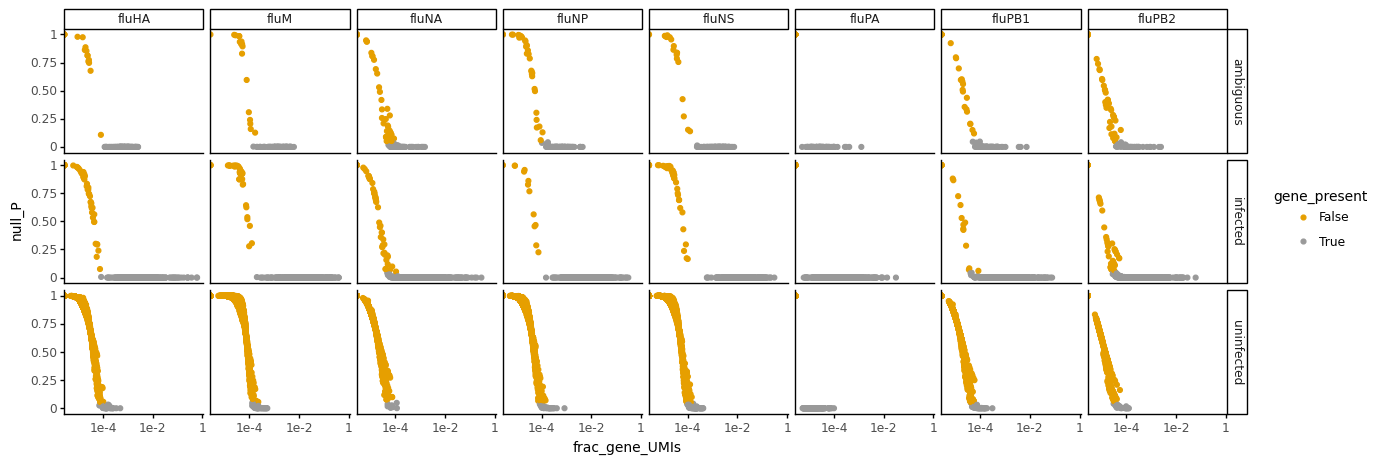

<ggplot: (8765619312854)>

In [76]:
fig = (p9.ggplot((viral_gene_expression_long),
                 p9.aes(x='frac_gene_UMIs',
                        y='null_P',
                        color='gene_present')) +
       p9.geom_point() +
       p9.facet_grid('infected~gene') +
       p9.theme(figure_size=(15, 5),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]) +
       p9.scale_x_log10()
       )
display(fig)

Color the proportion histogram by present/absent call:

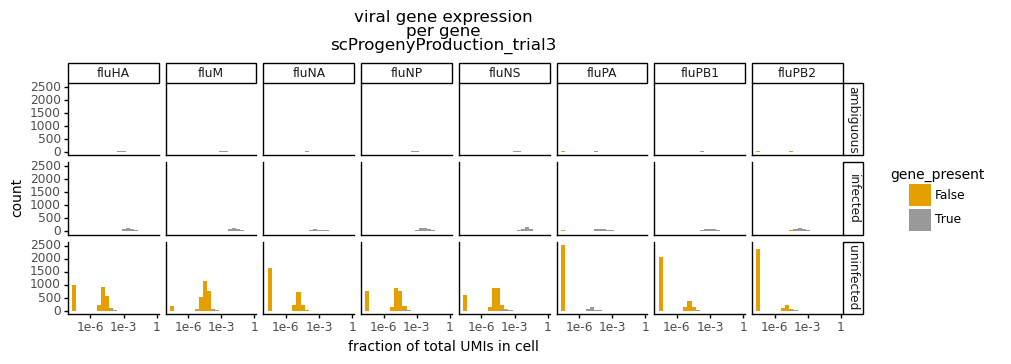

<ggplot: (8765606244295)>

In [77]:
fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs',
                        fill='gene_present')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10() +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]])
       )
display(fig)

In general, expression of all viral genes correlates with one another.  Let's check to see if we are correctly excluding viral genes that violate this correlation:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


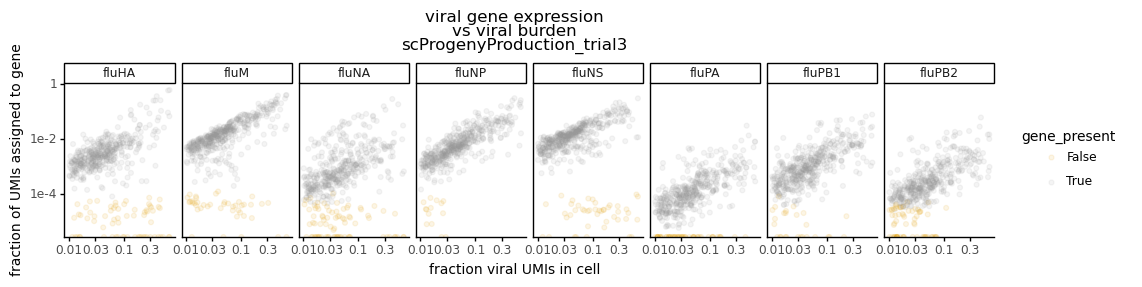

<ggplot: (8766313752043)>

In [78]:
fig = (p9.ggplot((viral_gene_expression_long
                  .query('infected == "infected"')),
                 p9.aes(x='frac_viral_UMIs',
                        y='frac_gene_UMIs',
                        color='gene_present')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='fraction viral UMIs in cell',
               y='fraction of UMIs assigned to gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(12, 2),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Annotate the fraction of cells that have each viral gene:

In [79]:
has_gene = pd.DataFrame(
    viral_gene_expression_long
    .query('infecting_viral_tag != "both"')
    .groupby(['infected',
              'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='prop_cells'))

has_gene

infected    gene  gene_present  prop_cells
0    ambiguous   fluHA          True    0.833333
1    ambiguous   fluHA         False    0.166667
2    ambiguous    fluM          True    0.842593
3    ambiguous    fluM         False    0.157407
4    ambiguous   fluNA          True    0.537037
5    ambiguous   fluNA         False    0.462963
6    ambiguous   fluNP          True    0.685185
7    ambiguous   fluNP         False    0.314815
8    ambiguous   fluNS          True    0.824074
9    ambiguous   fluNS         False    0.175926
10   ambiguous   fluPA          True    0.564815
11   ambiguous   fluPA         False    0.435185
12   ambiguous  fluPB1          True    0.638889
13   ambiguous  fluPB1         False    0.361111
14   ambiguous  fluPB2         False    0.611111
15   ambiguous  fluPB2          True    0.388889
16    infected   fluHA          True    0.880488
17    infected   fluHA         False    0.119512
18    infected    fluM          True    0.909756
19    infected    fluM         False    0.090244
20    infected   fluNA          True    0.829268
21    infected   fluNA         False    0.170732
22    infected   fluNP          True    0.965854
23    infected   fluNP         False    0.034146
24    infected   fluNS          True    0.904878
25    infected   fluNS         False    0.095122
26    infected   fluPA          True    0.887805
27    infected   fluPA         False    0.112195
28    infected  fluPB1          True    0.939024
29    infected  fluPB1         False    0.060976
30    infected  fluPB2          True    0.856098
31    infected  fluPB2         False    0.143902
32  uninfected   fluHA         False    0.986326
33  uninfected   fluHA          True    0.013674
34  uninfected    fluM         False    0.981288
35  uninfected    fluM          True    0.018712
36  uninfected   fluNA         False    0.997121
37  uninfected   fluNA          True    0.002879
38  uninfected   fluNP         False    0.984887
39  uninfected   fluNP          True    0.015113
40  uninfected   fluNS         False    0.974811
41  uninfected   fluNS          True    0.025189
42  uninfected   fluPA         False    0.907521
43  uninfected   fluPA          True    0.092479
44  uninfected  fluPB1         False    0.982728
45  uninfected  fluPB1          True    0.017272
46  uninfected  fluPB2         False    0.990284
47  uninfected  fluPB2          True    0.009716

Plot this fraction for each gene and infecting viral tag:

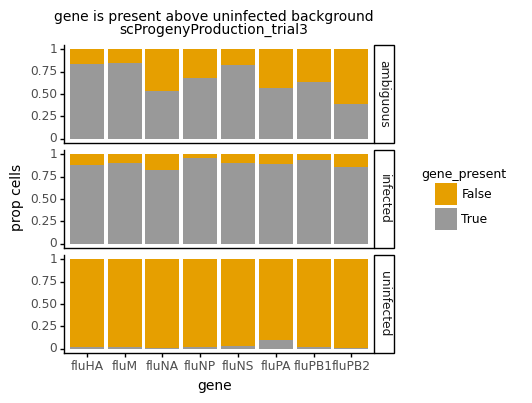

<ggplot: (8765619752656)>

In [80]:
fig = (p9.ggplot((has_gene),
                  p9.aes(x='gene',
                         y='prop_cells',
                         fill='gene_present')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('gene is present above uninfected background\n'
                         f'{expt}') +
              p9.ylab('prop cells') +
              p9.facet_grid('infected~') +
              p9.theme(figure_size=(4, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Tabulate the number of viral genes present in each cell

In [81]:
n_viral_genes = (pd.pivot_table(
    viral_gene_expression_long,
    index=['cell_barcode',
           'infected',
           'infecting_viral_tag',
           'total_UMIs'],
    values='gene_present',
    aggfunc=numpy.sum)
                 .reset_index()
                 .rename(columns={'gene_present':'n_viral_genes_present'}))

n_viral_genes

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0     AAACCCAGTAACAAGT  uninfected                none       47873   
1     AAACCCATCATTGCTT  uninfected                none       90114   
2     AAACGAAAGATGTTGA  uninfected                none      111630   
3     AAACGAAGTACTTCCC    infected                both       56828   
4     AAACGAAGTAGACGTG    infected                  wt      124341   
...                ...         ...                 ...         ...   
3367  TTTGATCTCCCGTTCA  uninfected                none       63150   
3368  TTTGATCTCGCATTGA    infected                  wt      170914   
3369  TTTGGAGAGTTGCCTA  uninfected                none       65941   
3370  TTTGGAGGTATCGTTG    infected                  wt      150130   
3371  TTTGTTGAGTGCAGCA  uninfected                none      135009   

      n_viral_genes_present  
0                         0  
1                         0  
2                         0  
3                         7  
4                         7  
...                     ...  
3367                      0  
3368                      8  
3369                      0  
3370                      8  
3371                      0  

[3372 rows x 5 columns]

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


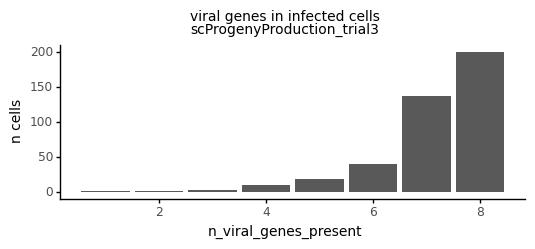

<ggplot: (8765606244807)>

In [82]:
fig = (p9.ggplot((n_viral_genes
                  .query('infected == "infected" and '
                         'infecting_viral_tag != "both"')),
                  p9.aes(x='n_viral_genes_present')) +
              p9.geom_bar(stat='count') +
              p9.ggtitle('viral genes in infected cells\n'
                         f'{expt}') +
              p9.ylab('n cells') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Add this information to viral_bc_freqs dataframe

In [83]:
viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=n_viral_genes,
    on=['cell_barcode',
        'infected',
        'infecting_viral_tag'],
    how='left')

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  ...  n_cell_bc  gt1_cell  \
0                 False       supernatant  ...        NaN     False   
1                 False       supernatant  ...        NaN     False   
2                 False       supernatant  ...        NaN     False   
3                 False  second_infection  ...        NaN     False   
4                 False  second_infection  ...        NaN     False   
...                 ...               ...  ...        ...       ...   
31696               NaN       supernatant  ...        NaN     False   
31697               NaN       supernatant  ...        NaN     False   
31698               NaN       supernatant  ...        NaN     False   
31699               NaN       supernatant  ...        NaN     False   
31700               NaN       supernatant  ...        NaN     False   

       n_viral_bc  coinfected  cell_total_frac_viral_bc_UMIs  \
0             NaN       False                            NaN   
1             NaN       False                            NaN   
2             NaN       False                            NaN   
3             NaN       False                            NaN   
4             NaN       False                            NaN   
...           ...         ...                            ...   
31696         NaN       False                            NaN   
31697         NaN       False                            NaN   
31698         NaN       False                            NaN   
31699         NaN       False                            NaN   
31700         NaN       False                            NaN   

       prop_cell_viral_bc_UMIs  viral_bc_rank  top_viral_bc  total_UMIs_y  \
0                          NaN            NaN         False       47873.0   
1                          NaN            NaN         False       47873.0   
2                          NaN            NaN         False       47873.0   
3                          NaN            NaN         False       47873.0   
4                          NaN            NaN         False       47873.0   
...                        ...            ...           ...           ...   
31696                      NaN            NaN         False           NaN   
31697                      NaN 

Plot the distribution of viral burden in infected cells binned by number of viral genes present.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


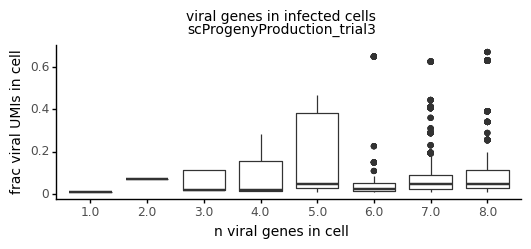

<ggplot: (8766305441747)>

In [84]:
fig = (p9.ggplot((viral_bc_freqs
                  .query('infected == "infected" and '
                         'infecting_viral_tag != "both"')),
                  p9.aes(x='factor(n_viral_genes_present)',
                         y='frac_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('viral genes in infected cells\n'
                         f'{expt}') +
              p9.xlab('n viral genes in cell') +
              p9.ylab('frac viral UMIs in cell') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Color the transcription-progeny plot by the number of viral genes present

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


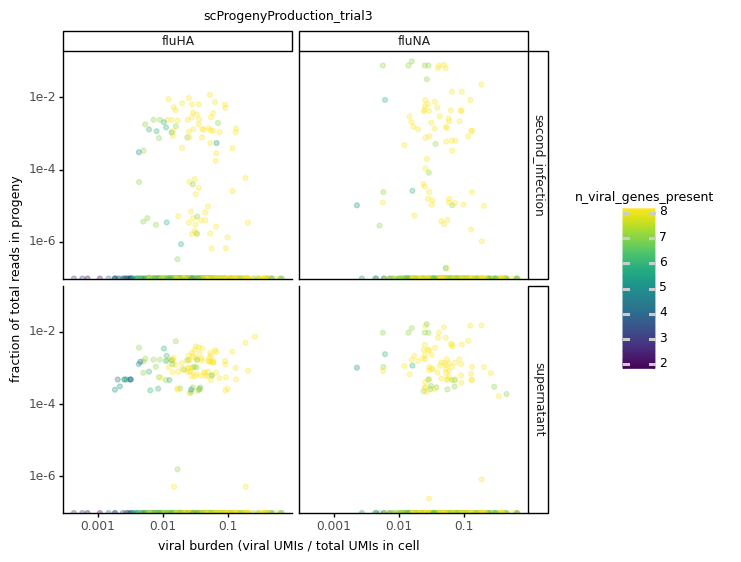

<ggplot: (8766305818275)>

In [85]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny',
                        color='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)


### Viral gene presence/absence as a function of other metrics

Plot relationship between n viral genes and viral burden

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 10643 rows containing missing values.


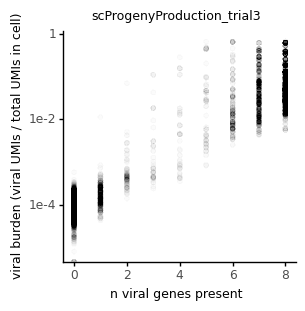

<ggplot: (8765620218606)>

In [86]:
fig = (p9.ggplot(viral_bc_freqs,
                 p9.aes(x='n_viral_genes_present',
                        y='frac_viral_UMIs')) +
       p9.geom_point(alpha=0.005) +
       p9.ggtitle(f'{expt}') +
       p9.scale_y_log10() +
       p9.labs(x='n viral genes present',
               y='viral burden (viral UMIs / total UMIs in cell)') +
       p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot relationship between n viral genes and viral progeny production in sup

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


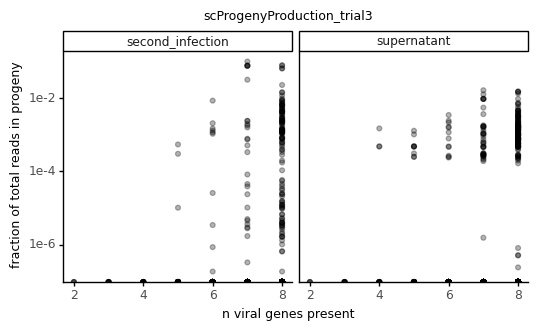

<ggplot: (8766306406223)>

In [87]:
fig = (p9.ggplot((viral_bc_freqs
                 .query('top_viral_bc == True')),
                 p9.aes(x='n_viral_genes_present',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~source') +
       p9.ggtitle(f'{expt}') +
       p9.scale_y_log10() +
       p9.labs(x='n viral genes present',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Check to see how viral gene presence/absence relates to the total number of UMIs generated for that cell to assess capture:

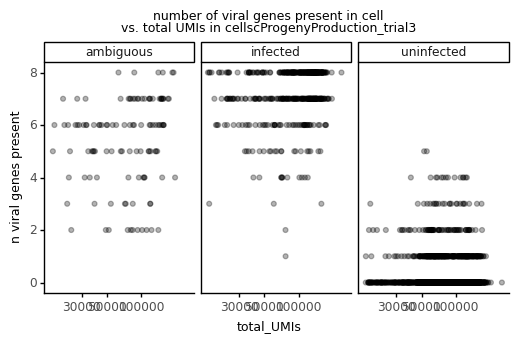

<ggplot: (8766305579304)>

In [88]:
fig = (p9.ggplot(n_viral_genes,
                 p9.aes(x='total_UMIs',
                        y='n_viral_genes_present')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~infected') +
       p9.ggtitle(f'number of viral genes present in cell\n'
                  f'vs. total UMIs in cell'
                  f'{expt}') +
       p9.scale_x_log10() +
       p9.labs(x='total_UMIs',
               y='n viral genes present') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

### All viral genes
Annotate cells that have all genes:

In [89]:
n_viral_genes['all_genes'] = (n_viral_genes['n_viral_genes_present'] == 8)
n_viral_genes

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0     AAACCCAGTAACAAGT  uninfected                none       47873   
1     AAACCCATCATTGCTT  uninfected                none       90114   
2     AAACGAAAGATGTTGA  uninfected                none      111630   
3     AAACGAAGTACTTCCC    infected                both       56828   
4     AAACGAAGTAGACGTG    infected                  wt      124341   
...                ...         ...                 ...         ...   
3367  TTTGATCTCCCGTTCA  uninfected                none       63150   
3368  TTTGATCTCGCATTGA    infected                  wt      170914   
3369  TTTGGAGAGTTGCCTA  uninfected                none       65941   
3370  TTTGGAGGTATCGTTG    infected                  wt      150130   
3371  TTTGTTGAGTGCAGCA  uninfected                none      135009   

      n_viral_genes_present  all_genes  
0                         0      False  
1                         0      False  
2                         0      False  
3                         7      False  
4                         7      False  
...                     ...        ...  
3367                      0      False  
3368                      8       True  
3369                      0      False  
3370                      8       True  
3371                      0      False  

[3372 rows x 6 columns]

Add this info to viral_bc_freqs

In [90]:
viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=n_viral_genes,
    on=['cell_barcode',
        'infected',
        'infecting_viral_tag',
        'n_viral_genes_present'],
    how='left')

viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  ...  n_viral_bc  coinfected  \
0                 False       supernatant  ...         NaN       False   
1                 False       supernatant  ...         NaN       False   
2                 False       supernatant  ...         NaN       False   
3                 False  second_infection  ...         NaN       False   
4                 False  second_infection  ...         NaN       False   
...                 ...               ...  ...         ...         ...   
31696               NaN       supernatant  ...         NaN       False   
31697               NaN       supernatant  ...         NaN       False   
31698               NaN       supernatant  ...         NaN       False   
31699               NaN       supernatant  ...         NaN       False   
31700               NaN       supernatant  ...         NaN       False   

       cell_total_frac_viral_bc_UMIs  prop_cell_viral_bc_UMIs  viral_bc_rank  \
0                                NaN                      NaN            NaN   
1                                NaN                      NaN            NaN   
2                                NaN                      NaN            NaN   
3                                NaN                      NaN            NaN   
4                                NaN                      NaN            NaN   
...                              ...                      ...            ...   
31696                            NaN                      NaN            NaN   
31697                            NaN                      NaN            NaN   
31698                            NaN                      NaN            NaN   
31699                            NaN                      NaN            NaN   
31700                            NaN                      NaN            NaN   

       top_viral_bc  total_UMIs_y  n_viral_genes_present  total_UMIs  \
0             False       47873.0                    0.0     47873.0   
1             False       47873.0                    0.0     47873.0   
2             False       47873.0                    0.0     47873.0   
3             False       47873.0                    0.0     47873.0   
4             False       47873.0                    0.0   

Plot transcription vs progeny, annotated by complete genome:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


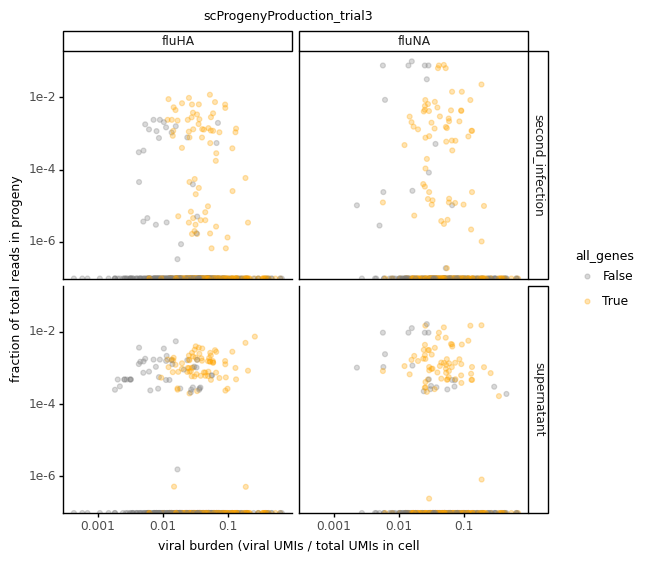

<ggplot: (8765606478936)>

In [91]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny',
                        color='all_genes')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

#### Cells expressing well-covered genes
The RNP and fluNA are not well-covered in our data. This is not a product of sequencing depth. It is either caused by failure to capture during RT or failure to align.

To infer which cells likely have a complete genome, we will label cells that have the 4 well covered genes: fluHA, fluM, fluNP, and fluNS

In [92]:
genes_present_in_cell = (
    viral_gene_expression_long
    .pivot(index='cell_barcode',
           columns='gene',
           values='gene_present')
    .reset_index()
)
genes_present_in_cell = genes_present_in_cell.assign(
    well_covered_genes = lambda x: (x['fluHA'] & x['fluM'] & x['fluNP'] & ['fluNS'])
)
display(genes_present_in_cell)

gene      cell_barcode  fluHA   fluM  fluNA  fluNP  fluNS  fluPA  fluPB1  \
0     AAACCCAGTAACAAGT  False  False  False  False  False  False   False   
1     AAACCCATCATTGCTT  False  False  False  False  False  False   False   
2     AAACGAAAGATGTTGA  False  False  False  False  False  False   False   
3     AAACGAAGTACTTCCC  False   True   True   True   True   True    True   
4     AAACGAAGTAGACGTG   True   True   True   True   True   True    True   
...                ...    ...    ...    ...    ...    ...    ...     ...   
3367  TTTGATCTCCCGTTCA  False  False  False  False  False  False   False   
3368  TTTGATCTCGCATTGA   True   True   True   True   True   True    True   
3369  TTTGGAGAGTTGCCTA  False  False  False  False  False  False   False   
3370  TTTGGAGGTATCGTTG   True   True   True   True   True   True    True   
3371  TTTGTTGAGTGCAGCA  False  False  False  False  False  False   False   

gene  fluPB2  well_covered_genes  
0      False               False  
1      False               False  
2      False               False  
3       True               False  
4      False                True  
...      ...                 ...  
3367   False               False  
3368    True                True  
3369   False               False  
3370    True                True  
3371   False               False  

[3372 rows x 10 columns]

In [93]:
genes_present_in_cell['well_covered_genes'].value_counts()

False    2930
True      442
Name: well_covered_genes, dtype: int64

Integrate back into viral_bc_freqs

In [94]:
viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=genes_present_in_cell[['cell_barcode', 'well_covered_genes']],
    on='cell_barcode',
    how='left',
    validate='many_to_one'
)
display(viral_bc_freqs)

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31696               NaN         NaN                  wt              NaN   
31697               NaN         NaN                  wt              NaN   
31698               NaN         NaN                  wt              NaN   
31699               NaN         NaN                  wt              NaN   
31700               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31696  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31697  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31698  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31699  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31700  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  ...  coinfected  \
0                 False       supernatant  ...       False   
1                 False       supernatant  ...       False   
2                 False       supernatant  ...       False   
3                 False  second_infection  ...       False   
4                 False  second_infection  ...       False   
...                 ...               ...  ...         ...   
31696               NaN       supernatant  ...       False   
31697               NaN       supernatant  ...       False   
31698               NaN       supernatant  ...       False   
31699               NaN       supernatant  ...       False   
31700               NaN       supernatant  ...       False   

       cell_total_frac_viral_bc_UMIs  prop_cell_viral_bc_UMIs  viral_bc_rank  \
0                                NaN                      NaN            NaN   
1                                NaN                      NaN            NaN   
2                                NaN                      NaN            NaN   
3                                NaN                      NaN            NaN   
4                                NaN                      NaN            NaN   
...                              ...                      ...            ...   
31696                            NaN                      NaN            NaN   
31697                            NaN                      NaN            NaN   
31698                            NaN                      NaN            NaN   
31699                            NaN                      NaN            NaN   
31700                            NaN                      NaN            NaN   

       top_viral_bc  total_UMIs_y  n_viral_genes_present  total_UMIs  \
0             False       47873.0                    0.0     47873.0   
1             False       47873.0                    0.0     47873.0   
2             False       47873.0                    0.0     47873.0   
3             False       47873.0                    0.0     47873.0   
4             False       47873.0                    0.0     47873.0   
...             ...           ...                    ...         ...   
31696         False           NaN                    NaN   

#### Annotate whether cells contribute progeny
If you simply take `freq_progeny > 0`, the result will be on a per viral bc basis.

We want to define this on a per cell-gene basis and a per cell basis. Progeny contribution is first defined on a per cell-gene basis (fluHA or fluNA). Then, on a per cell basis (cell barcode with any progeny on either fluHA or fluNA).

All contribute_progeny calls are made separately for second infection and supernatant sources.

In [95]:
contribute_progeny_df = (
    viral_bc_freqs[['cell_barcode',
                    'gene',
                    'source',
                    'viral_barcode',
                    'count_progeny']])

# sum progeny for gene and source
contribute_progeny_df = pd.merge(
    left=contribute_progeny_df,
    right=(contribute_progeny_df
           .groupby(['cell_barcode',
                     'source',
                     'gene'])
           ['count_progeny']
           .sum()
           .reset_index()
           .rename(columns={'count_progeny':'gene_source_progeny_sum'})),
    on=['cell_barcode',
        'source',
        'gene'],
    how='left')

contribute_progeny_df['contributes_gene_source_progeny'] = (
    contribute_progeny_df['gene_source_progeny_sum'] > 0
)

# sum progeny for source
contribute_progeny_df = pd.merge(
    left=contribute_progeny_df,
    right=(contribute_progeny_df
           .groupby(['cell_barcode',
                     'source'])
           ['count_progeny']
           .sum()
           .reset_index()
           .rename(columns={'count_progeny':'source_progeny_sum'})),
    on=['cell_barcode',
        'source'],
    how='left')

contribute_progeny_df['contributes_source_progeny'] = (
    contribute_progeny_df['source_progeny_sum'] > 0
)

contribute_progeny_df

cell_barcode   gene            source     viral_barcode  \
0      AAACCCAGTAACAAGT  fluHA       supernatant  GGAGCATAGATCAGGA   
1      AAACCCAGTAACAAGT  fluHA       supernatant  TTTCGGTTGATTATTG   
2      AAACCCAGTAACAAGT  fluNA       supernatant               NaN   
3      AAACCCAGTAACAAGT  fluHA  second_infection  GGAGCATAGATCAGGA   
4      AAACCCAGTAACAAGT  fluHA  second_infection  TTTCGGTTGATTATTG   
...                 ...    ...               ...               ...   
31696               NaN  fluNA       supernatant  TTTTCGGGATCATTGC   
31697               NaN  fluNA       supernatant  TTTTCGTGAAAAGAGA   
31698               NaN  fluNA       supernatant  TTTTGGTTGTGAGGTG   
31699               NaN  fluNA       supernatant  TTTTGTTACATCATCT   
31700               NaN  fluNA       supernatant  TTTTTAGGGGTAACTG   

       count_progeny  gene_source_progeny_sum  \
0                0.0                      0.0   
1                0.0                      0.0   
2                0.0                      0.0   
3                0.0                      0.0   
4                0.0                      0.0   
...              ...                      ...   
31696         7457.0                      NaN   
31697         2638.5                      NaN   
31698            0.5                      NaN   
31699            0.5                      NaN   
31700            0.5                      NaN   

       contributes_gene_source_progeny  source_progeny_sum  \
0                                False                 0.0   
1                                False                 0.0   
2                                False                 0.0   
3                                False                 0.0   
4                                False                 0.0   
...                                ...                 ...   
31696                            False                 NaN   
31697                            False                 NaN   
31698                            False                 NaN   
31699                            False                 NaN   
31700                            False                 NaN   

       contributes_source_progeny  
0                           False  
1                           False  
2                           False  
3                           False  
4                           False  
...                           ...  
31696                       False  
31697                       False  
31698                       False  
31699                       False  
31700                       False  

[31701 rows x 9 columns]

In [96]:
contribute_progeny_df.query('cell_barcode == "TTTGGAGGTATCGTTG"')

cell_barcode   gene            source     viral_barcode  \
12162  TTTGGAGGTATCGTTG  fluHA       supernatant  TGCAACTTACGCAGAG   
12163  TTTGGAGGTATCGTTG  fluHA       supernatant  AGAAAACTTCATCGCG   
12164  TTTGGAGGTATCGTTG  fluHA       supernatant  AGTAAACTTCCTCGCG   
12165  TTTGGAGGTATCGTTG  fluNA       supernatant  ACATCTTATTTACACG   
12166  TTTGGAGGTATCGTTG  fluHA  second_infection  TGCAACTTACGCAGAG   
12167  TTTGGAGGTATCGTTG  fluHA  second_infection  AGAAAACTTCATCGCG   
12168  TTTGGAGGTATCGTTG  fluHA  second_infection  AGTAAACTTCCTCGCG   
12169  TTTGGAGGTATCGTTG  fluNA  second_infection  ACATCTTATTTACACG   

       count_progeny  gene_source_progeny_sum  \
12162        14474.5                  15986.0   
12163            0.0                  15986.0   
12164         1511.5                  15986.0   
12165         3320.5                   3320.5   
12166            0.0                      0.0   
12167            0.0                      0.0   
12168            0.0                      0.0   
12169           50.0                     50.0   

       contributes_gene_source_progeny  source_progeny_sum  \
12162                             True             19306.5   
12163                             True             19306.5   
12164                             True             19306.5   
12165                             True             19306.5   
12166                            False                50.0   
12167                            False                50.0   
12168                            False                50.0   
12169                             True                50.0   

       contributes_source_progeny  
12162                        True  
12163                        True  
12164                        True  
12165                        True  
12166                        True  
12167                        True  
12168                        True  
12169                        True

Integrate this data back into `viral_bc_freqs`

In [97]:
viral_bc_freqs = (pd.merge(
                    left=viral_bc_freqs,
                    right=contribute_progeny_df,
                    on=['cell_barcode',
                        'gene',
                        'source',
                        'viral_barcode',
                        'count_progeny'],
                    how='left')
                  .drop_duplicates())
viral_bc_freqs

cell_barcode    infected infecting_viral_tag  frac_viral_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none         0.000125   
1      AAACCCAGTAACAAGT  uninfected                none         0.000125   
2      AAACCCAGTAACAAGT  uninfected                none         0.000125   
3      AAACCCAGTAACAAGT  uninfected                none         0.000125   
4      AAACCCAGTAACAAGT  uninfected                none         0.000125   
...                 ...         ...                 ...              ...   
31732               NaN         NaN                  wt              NaN   
31733               NaN         NaN                  wt              NaN   
31734               NaN         NaN                  wt              NaN   
31735               NaN         NaN                  wt              NaN   
31736               NaN         NaN                  wt              NaN   

        gene     viral_barcode  viral_bc_UMIs  frac_viral_bc_UMIs  \
0      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
1      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
2      fluNA               NaN            0.0            0.000000   
3      fluHA  GGAGCATAGATCAGGA            1.0            0.000021   
4      fluHA  TTTCGGTTGATTATTG            1.0            0.000021   
...      ...               ...            ...                 ...   
31732  fluNA  TTTTCGGGATCATTGC            NaN                 NaN   
31733  fluNA  TTTTCGTGAAAAGAGA            NaN                 NaN   
31734  fluNA  TTTTGGTTGTGAGGTG            NaN                 NaN   
31735  fluNA  TTTTGTTACATCATCT            NaN                 NaN   
31736  fluNA  TTTTTAGGGGTAACTG            NaN                 NaN   

      reject_uninfected            source  ...  top_viral_bc  total_UMIs_y  \
0                 False       supernatant  ...         False       47873.0   
1                 False       supernatant  ...         False       47873.0   
2                 False       supernatant  ...         False       47873.0   
3                 False  second_infection  ...         False       47873.0   
4                 False  second_infection  ...         False       47873.0   
...                 ...               ...  ...           ...           ...   
31732               NaN       supernatant  ...         False           NaN   
31733               NaN       supernatant  ...         False           NaN   
31734               NaN       supernatant  ...         False           NaN   
31735               NaN       supernatant  ...         False           NaN   
31736               NaN       supernatant  ...         False           NaN   

       n_viral_genes_present  total_UMIs  all_genes  well_covered_genes  \
0                        0.0     47873.0      False               False   
1                        0.0     47873.0      False               False   
2                        0.0     47873.0      False               False   
3                        0.0     47873.0      False               False   
4                        0.0     47873.0      False               False   
...                      ...         ...        ...                 ...   
31732                    NaN         NaN        NaN                 NaN   
31733                    NaN         NaN        NaN                 NaN   
31734                    NaN         NaN        NaN                 NaN   
31735                    NaN         NaN        NaN                 NaN   
31736                    NaN         NaN        NaN                 NaN   

       gene_source_progeny_sum  contributes_gene_source_progeny  \
0                          0.0                            False   
1                          0.0                            False   
2                          0.0                            False   
3                          0.0                            False   
4                          0.0                            False   
...                        ..

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


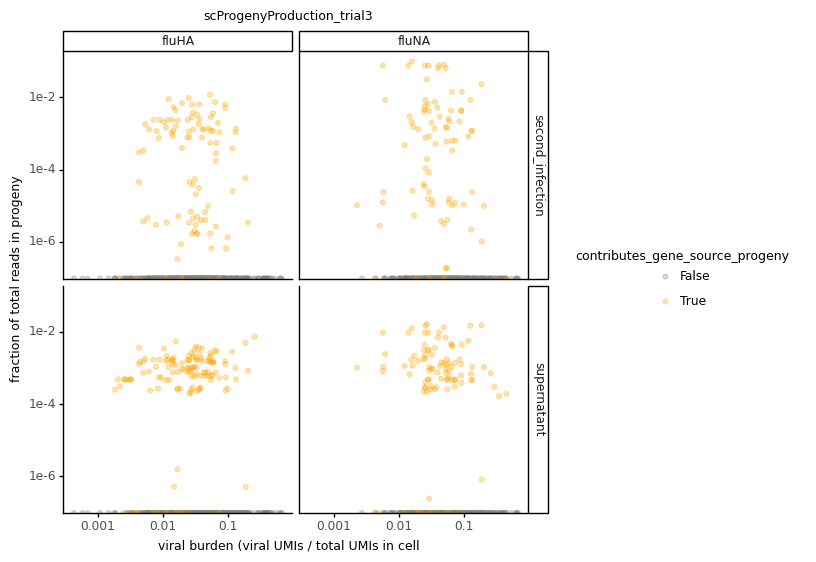

<ggplot: (8765606200077)>

In [98]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny',
                        color='contributes_gene_source_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 6),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))

display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


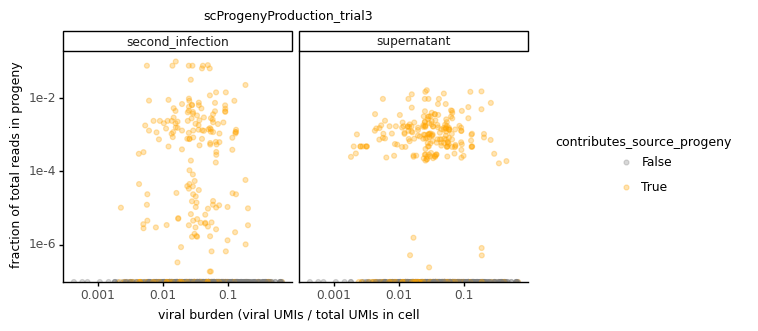

<ggplot: (8765622485492)>

In [99]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny',
                        color='contributes_source_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~source') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
               y='fraction of total reads in progeny') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))

display(fig)

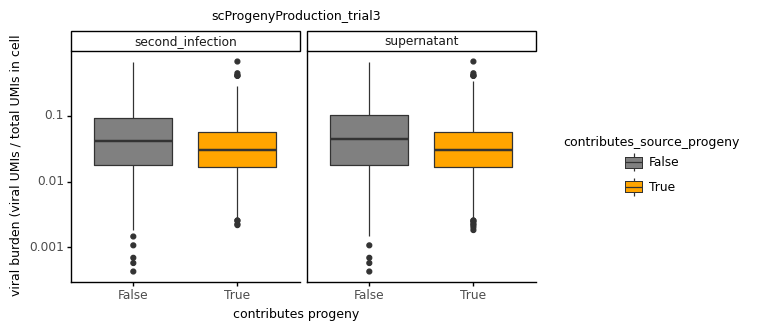

<ggplot: (8765619805817)>

In [100]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('top_viral_bc == True',
                        engine='python'),
                 p9.aes(x='contributes_source_progeny',
                        y='frac_viral_UMIs',
                        fill='contributes_source_progeny')) +
       p9.geom_boxplot() +
       p9.facet_grid('~source') +
       p9.scale_y_log10() +
       p9.ggtitle(f'{expt}') +
       p9.labs(y='viral burden (viral UMIs / total UMIs in cell',
               x='contributes progeny') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(values=['grey','orange']))

display(fig)

Plot density plots and histogram of cells that contribute progeny vs don't contribute progeny

*NB I think this counts each viral bc as its own entity. Therefore, counts are not unique cell barcodes, but rather skewed by cells with high numbers of viral bc (significant or not). This plot is bad.*

In [101]:
# fig = (p9.ggplot(viral_bc_freqs
#                  .fillna(0)
#                  .query('top_viral_bc == True',
#                         engine='python'),
#                  p9.aes(x='frac_viral_UMIs',
#                         fill='contributes_gene_source_progeny')) +
#        p9.geom_density(alpha=0.2) +
#        p9.facet_grid('source~gene') +
#        p9.ggtitle(f'{expt}') +
#        p9.scale_x_log10() +
#        p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
#                y='frac cells') +
#        p9.theme(figure_size=(6, 6),
#                 plot_title=p9.element_text(size=9),
#                 axis_title=p9.element_text(size=9),
#                 legend_title=p9.element_text(size=9),
#                 legend_title_align='center') +
#        p9.scale_fill_manual(values=['grey','orange']))

# display(fig)

In [102]:
# fig = (p9.ggplot(viral_bc_freqs
#                  .query('top_viral_bc == True',
#                         engine='python'),
#                  p9.aes(x='frac_viral_UMIs',
#                         fill='contributes_gene_source_progeny')) +
#        p9.geom_histogram() +
#        p9.facet_grid('source~gene') +
#        p9.ggtitle(f'{expt}') +
#        p9.scale_x_log10() +
#        p9.scale_y_log10() +
#        p9.labs(x='viral burden (viral UMIs / total UMIs in cell',
#                y='n cells') +
#        p9.theme(figure_size=(6, 6),
#                 plot_title=p9.element_text(size=9),
#                 axis_title=p9.element_text(size=9),
#                 legend_title=p9.element_text(size=9),
#                 legend_title_align='center') +
#        p9.scale_fill_manual(values=['grey','orange']))

# display(fig)

Look at the proportion of infected cells that contribute progeny vs those that don't and how that relates to having all viral genes. A priori, I would expect many more cells that contribute progeny to have all 8 genes than cells that don't.

In [103]:
progeny_full_genome = pd.DataFrame(
    viral_bc_freqs
    .query('infected == "infected" and '
           'infecting_viral_tag != "both"')
    .groupby(['source', 'contributes_source_progeny', 'all_genes'])
    ['cell_barcode']
    .nunique()
    .reset_index(name='n_cells'))

progeny_full_genome = (progeny_full_genome.pivot(
    index=['source','all_genes'],
    columns='contributes_source_progeny',
    values='n_cells'))

progeny_full_genome

contributes_source_progeny  False  True 
source           all_genes              
second_infection False        153     57
                 True          80    120
supernatant      False        134     76
                 True          62    138

Run a chi-square test to see if the ratio of cells with a full genome differs in cells that contribute progeny vs cells that do not.

In [104]:
for source in ['supernatant', 'second_infection']:
    chi_data = (progeny_full_genome
                .query(f'source == "{source}"'))
    chi_result = (scipy
                  .stats
                  .chi2_contingency(observed=chi_data))
                
    print(f'Progeny source: {source}')
    print('Is the probability of contributing progeny different '
          'for cells with all 8 genes vs cells missing some genes?')

    print(f'The p-value of observing these values by chance is {chi_result[1]:.10f}.\n')

Progeny source: supernatant
Is the probability of contributing progeny different for cells with all 8 genes vs cells missing some genes?
The p-value of observing these values by chance is 0.0000000001.

Progeny source: second_infection
Is the probability of contributing progeny different for cells with all 8 genes vs cells missing some genes?
The p-value of observing these values by chance is 0.0000000000.



Visualize this data as a fraction of cells with or without all genes:

In [105]:
## Need help figuring out how to summarize this data for plotting.

# progeny_full_genome_normalized = pd.DataFrame(
#     viral_bc_freqs
#     .query('infected == True and '
#            'infecting_viral_tag != "both"')
#     .groupby(['source', 'contribute_progeny'])
#     ['all_genes']
#     .value_counts(normalize=True)
#     .reset_index(name='prop_cells'))
# progeny_full_genome_normalized

# fig = (p9.ggplot((progeny_full_genome_normalized),
#                   p9.aes(x='contribute_progeny',
#                          y='prop_cells',
#                          fill='all_genes')) +
#               p9.geom_bar(stat='identity') +
#               p9.facet_grid('source~') +
#               p9.ggtitle('infected cells\n'
#                          f'{expt}') +
#               p9.labs(x='cell contributes progeny', y='prop cells') + 
#               p9.theme(figure_size=(3, 4),
#                        plot_title=p9.element_text(size=10),
#                        axis_title=p9.element_text(size=10),
#                        legend_title=p9.element_text(size=9),
#                        legend_title_align='center') +
#               p9.scale_fill_manual(CBPALETTE[0:]))
# display(fig)

Plot the distribution of viral genes present in each cell, colored by whether they contribute progeny or not.

In [106]:
n_genes_summarized = (
    viral_bc_freqs
    .query('infected == "infected" and '
           'infecting_viral_tag != "both"')
    .groupby(['source', 'contributes_source_progeny', 'n_viral_genes_present'])
    ['cell_barcode']
    .nunique()
    .reset_index(name='n_cells')
)

n_genes_normalized = pd.merge(
    left=n_genes_summarized,
    right=(n_genes_summarized
           .groupby(['source','contributes_source_progeny'])
           ['n_cells']
           .sum()
           .reset_index()
           .rename(columns={'n_cells':'total'})),
    on=['source', 'contributes_source_progeny'],
    how='left',
    validate='many_to_one'
)

n_genes_normalized['frac_cells'] = (n_genes_normalized['n_cells'] /
                                    n_genes_normalized['total'])

n_genes_normalized

source  contributes_source_progeny  n_viral_genes_present  \
0   second_infection                       False                    1.0   
1   second_infection                       False                    3.0   
2   second_infection                       False                    4.0   
3   second_infection                       False                    5.0   
4   second_infection                       False                    6.0   
5   second_infection                       False                    7.0   
6   second_infection                       False                    8.0   
7   second_infection                        True                    2.0   
8   second_infection                        True                    4.0   
9   second_infection                        True                    5.0   
10  second_infection                        True                    6.0   
11  second_infection                        True                    7.0   
12  second_infection                        True                    8.0   
13       supernatant                       False                    1.0   
14       supernatant                       False                    3.0   
15       supernatant                       False                    4.0   
16       supernatant                       False                    5.0   
17       supernatant                       False                    6.0   
18       supernatant                       False                    7.0   
19       supernatant                       False                    8.0   
20       supernatant                        True                    2.0   
21       supernatant                        True                    4.0   
22       supernatant                        True                    5.0   
23       supernatant                        True                    6.0   
24       supernatant                        True                    7.0   
25       supernatant                        True                    8.0   

    n_cells  total  frac_cells  
0         1    233    0.004292  
1         3    233    0.012876  
2         9    233    0.038627  
3        17    233    0.072961  
4        27    233    0.115880  
5        96    233    0.412017  
6        80    233    0.343348  
7         1    177    0.005650  
8         1    177    0.005650  
9         1    177    0.005650  
10       13    177    0.073446  
11       41    177    0.231638  
12      120    177    0.677966  
13        1    196    0.005102  
14        3    196    0.015306  
15        8    196    0.040816  
16       16    196    0.081633  
17       28    196    0.142857  
18       78    196    0.397959  
19       62    196    0.316327  
20        1    214    0.004673  
21        2    214    0.009346  
22        2    214    0.009346  
23       12    214    0.056075  
24       59    214    0.275701  
25      138    214    0.644860

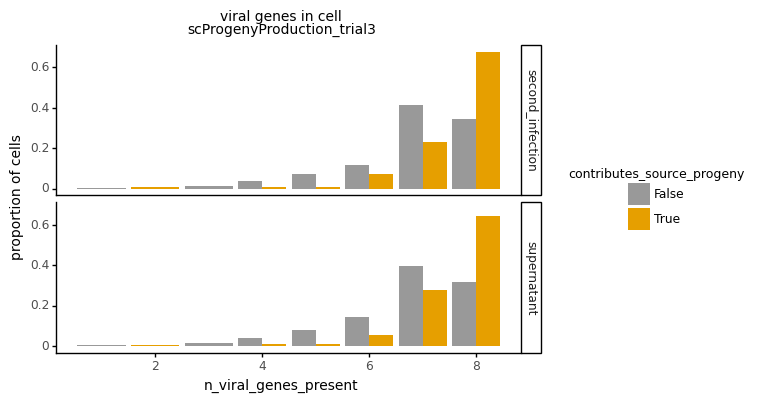

<ggplot: (8765606209940)>

In [107]:
fig = (p9.ggplot(n_genes_normalized,
                 p9.aes(x='n_viral_genes_present',
                        y='frac_cells',
                        fill='contributes_source_progeny')) +
              p9.geom_bar(stat='identity', position='dodge') +
              p9.facet_grid('source~') +
              p9.ggtitle('viral genes in cell\n'
                         f'{expt}') +
              p9.ylab('proportion of cells') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Progeny contribution by 4 well covered genes
How does progeny contribution compare in cells that express all 4 well covered genes compared to cells that do not?

In [108]:
well_covered_summarized = (
    viral_bc_freqs
    .query('infected == "infected" and '
           'infecting_viral_tag != "both"')
    .groupby(['source', 'contributes_source_progeny', 'well_covered_genes'])
    ['cell_barcode']
    .nunique()
    .reset_index(name='n_cells')
)

well_covered_normalized = pd.merge(
    left=well_covered_summarized,
    right=(well_covered_summarized
           .groupby(['source','well_covered_genes'])
           ['n_cells']
           .sum()
           .reset_index()
           .rename(columns={'n_cells':'total'})),
    on=['source', 'well_covered_genes'],
    how='left',
    validate='many_to_one'
)

well_covered_normalized['frac_cells'] = (well_covered_normalized['n_cells'] /
                                    well_covered_normalized['total'])

well_covered_normalized

source  contributes_source_progeny  well_covered_genes  n_cells  \
0  second_infection                       False               False       73   
1  second_infection                       False                True      160   
2  second_infection                        True               False       11   
3  second_infection                        True                True      166   
4       supernatant                       False               False       65   
5       supernatant                       False                True      131   
6       supernatant                        True               False       19   
7       supernatant                        True                True      195   

   total  frac_cells  
0     84    0.869048  
1    326    0.490798  
2     84    0.130952  
3    326    0.509202  
4     84    0.773810  
5    326    0.401840  
6     84    0.226190  
7    326    0.598160

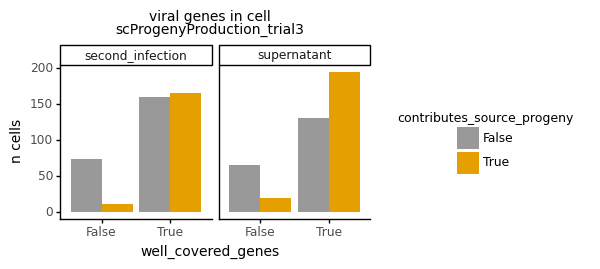

<ggplot: (8766305827844)>

In [109]:
fig = (p9.ggplot(well_covered_normalized,
                 p9.aes(x='well_covered_genes',
                        y='n_cells',
                        fill='contributes_source_progeny')) +
              p9.geom_bar(stat='identity', position='dodge') +
              p9.facet_grid('~source') +
              p9.ggtitle('viral genes in cell\n'
                         f'{expt}') +
              p9.ylab('n cells') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

## What is the effect of each gene on viral outcomes

Relationship between each gene's expression adn viral burden

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


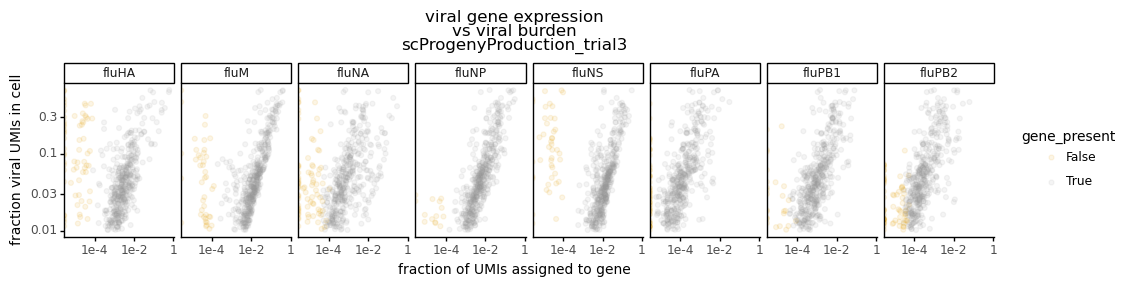

<ggplot: (8766305728290)>

In [110]:
fig = (p9.ggplot((viral_gene_expression_long
                  .query('infected == "infected"')),
                 p9.aes(x='frac_gene_UMIs',
                        y='frac_viral_UMIs',
                        color='gene_present')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs assigned to gene',
               y='fraction viral UMIs in cell') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(12, 2),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_color_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Bring in progeny production information:

In [111]:
(viral_bc_freqs[['cell_barcode',
                           'source',
                           'contributes_source_progeny']]
           .drop_duplicates())

cell_barcode            source  contributes_source_progeny
0      AAACCCAGTAACAAGT       supernatant                       False
3      AAACCCAGTAACAAGT  second_infection                       False
6      GTTGAACTCTATGTGG       supernatant                       False
9      GTTGAACTCTATGTGG  second_infection                       False
12     AAACGAAAGATGTTGA       supernatant                       False
...                 ...               ...                         ...
21050  TTTCGATTCCCTCAAC  second_infection                       False
21052  TTTGATCTCGCATTGA       supernatant                       False
21055  TTTGATCTCGCATTGA  second_infection                       False
21058               NaN  second_infection                       False
25061               NaN       supernatant                       False

[6746 rows x 3 columns]

In [112]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_bc_freqs[['cell_barcode',
                           'source',
                           'contributes_source_progeny']]
           .drop_duplicates()),
    on=['cell_barcode'],
    how='left'
)

viral_gene_expression_long

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0      AAACCCAGTAACAAGT  uninfected                none       47873   
1      AAACCCAGTAACAAGT  uninfected                none       47873   
2      AAACCCATCATTGCTT  uninfected                none       90114   
3      AAACCCATCATTGCTT  uninfected                none       90114   
4      AAACGAAAGATGTTGA  uninfected                none      111630   
...                 ...         ...                 ...         ...   
53947  TTTGGAGAGTTGCCTA  uninfected                none       65941   
53948  TTTGGAGGTATCGTTG    infected                  wt      150130   
53949  TTTGGAGGTATCGTTG    infected                  wt      150130   
53950  TTTGTTGAGTGCAGCA  uninfected                none      135009   
53951  TTTGTTGAGTGCAGCA  uninfected                none      135009   

       viral_UMIs    gene  gene_UMIs  frac_viral_UMIs  frac_gene_UMIs  \
0               6  fluPB2          0         0.000125        0.000000   
1               6  fluPB2          0         0.000125        0.000000   
2              10  fluPB2          1         0.000111        0.000011   
3              10  fluPB2          1         0.000111        0.000011   
4              18  fluPB2          0         0.000161        0.000000   
...           ...     ...        ...              ...             ...   
53947          12   fluNS          4         0.000182        0.000061   
53948        3526   fluNS       1230         0.023486        0.008193   
53949        3526   fluNS       1230         0.023486        0.008193   
53950           8   fluNS          3         0.000059        0.000022   
53951           8   fluNS          3         0.000059        0.000022   

       prop_viral_UMIs  limit_frac  limit_UMIs    null_P  gene_present  \
0             0.000000    0.000010    0.467492  1.000000         False   
1             0.000000    0.000010    0.467492  1.000000         False   
2             0.100000    0.000010    0.879985  0.585211         False   
3             0.100000    0.000010    0.879985  0.585211         False   
4             0.000000    0.000010    1.090094  1.000000         False   
...                ...         ...         ...       ...           ...   
53947         0.333333    0.000053    3.485201  0.460171         False   
53948         0.348837    0.000053    7.934870  0.000000          True   
53949         0.348837    0.000053    7.934870  0.000000          True   
53950         0.375000    0.000053    7.135674  0.973252         False   
53951         0.375000    0.000053    7.135674  0.973252         False   

                 source  contributes_source_progeny  
0           supernatant                       False  
1      second_infection                       False  
2           supernatant                       False  
3      second_infection                       False  
4           supernatant                       False  
...                 ...                         ...  
53947  second_infection                       False  
53948       supernatant                        True  
53949  second_infection                        True  
53950       supernatant                       False  
53951  second_infection                       False  

[53952 rows x 16 columns]

In [113]:
each_gene_progeny = (viral_gene_expression_long
                     .query('infected == "infected" and '
                            'infecting_viral_tag != "both"')
                     .groupby(['source', 'gene','gene_present'])
                     ['contributes_source_progeny']
                     .value_counts()
                     .reset_index(name='n_cells'))

each_gene_progeny_normalized = pd.merge(
    left=each_gene_progeny,
    right=(each_gene_progeny
           .groupby(['source','gene','contributes_source_progeny'])
           ['n_cells']
           .sum()
           .reset_index()
           .rename(columns={'n_cells':'total'})),
    on=['source', 'gene', 'contributes_source_progeny'],
    how='left',
    validate='many_to_one'
)

each_gene_progeny_normalized['frac_cells'] = (each_gene_progeny_normalized['n_cells'] /
                                              each_gene_progeny_normalized['total'])


each_gene_progeny_normalized

source    gene  gene_present  contributes_source_progeny  \
0   second_infection   fluHA         False                       False   
1   second_infection   fluHA         False                        True   
2   second_infection   fluHA          True                       False   
3   second_infection   fluHA          True                        True   
4   second_infection    fluM         False                       False   
..               ...     ...           ...                         ...   
59       supernatant  fluPB1          True                       False   
60       supernatant  fluPB2         False                       False   
61       supernatant  fluPB2         False                        True   
62       supernatant  fluPB2          True                        True   
63       supernatant  fluPB2          True                       False   

    n_cells  total  frac_cells  
0        43    233    0.184549  
1         6    177    0.033898  
2       190    233    0.815451  
3       171    177    0.966102  
4        32    233    0.137339  
..      ...    ...         ...  
59      179    196    0.913265  
60       35    196    0.178571  
61       24    214    0.112150  
62      190    214    0.887850  
63      161    196    0.821429  

[64 rows x 7 columns]

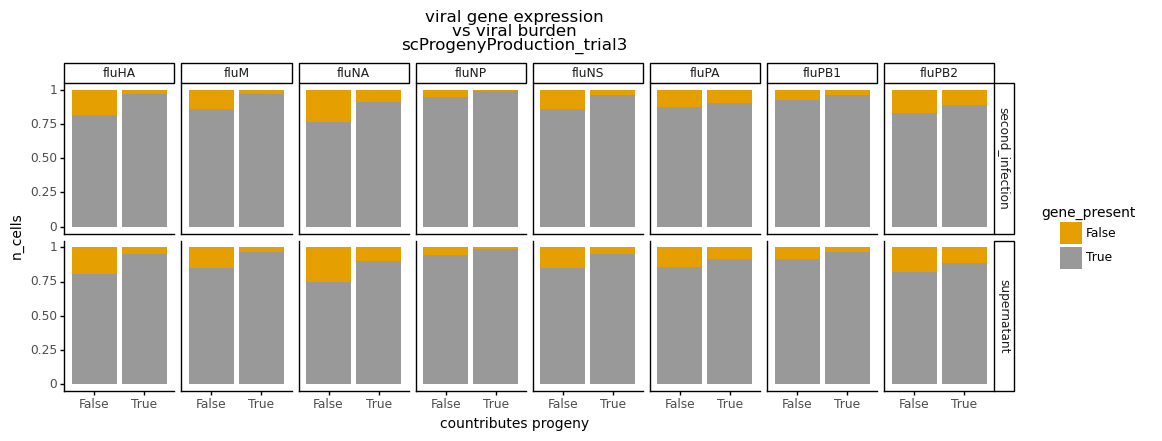

<ggplot: (8765619330407)>

In [114]:
fig = (p9.ggplot(each_gene_progeny_normalized,
                 p9.aes(x='factor(contributes_source_progeny)',
                        y='frac_cells',
                        fill='gene_present')) +
       p9.geom_bar(stat='identity') +
       p9.facet_grid('source~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'vs viral burden\n'
                  f'{expt}') +
       p9.labs(x='countributes progeny',
               y='n_cells') +
       p9.theme(figure_size=(12, 4),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

### Complementation by co-infection
Summarize presence/absence of each viral gene by whether the cell was infected by 1 virion or > 1 virion.

Bring in coinfection information:

In [115]:
(viral_bc_freqs[['cell_barcode',
                 'gene',
                 'coinfected']]
 .drop_duplicates()
 .rename(columns={'gene':'viral_bc_segment'}))

cell_barcode viral_bc_segment  coinfected
0      AAACCCAGTAACAAGT            fluHA       False
2      AAACCCAGTAACAAGT            fluNA       False
6      GTTGAACTCTATGTGG            fluHA       False
8      GTTGAACTCTATGTGG            fluNA       False
12     AAACGAAAGATGTTGA            fluHA       False
...                 ...              ...         ...
21049  TTTCGATTCCCTCAAC            fluNA       False
21052  TTTGATCTCGCATTGA            fluHA       False
21054  TTTGATCTCGCATTGA            fluNA       False
21058               NaN            fluHA       False
22040               NaN            fluNA       False

[6746 rows x 3 columns]

In [116]:
viral_gene_expression_long = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_bc_freqs[['cell_barcode',
                 'gene',
                 'coinfected']]
           .drop_duplicates()
           .rename(columns={'gene':'viral_bc_segment'})),
    on=['cell_barcode'],
    how='left'
)

viral_gene_expression_long

cell_barcode    infected infecting_viral_tag  total_UMIs  \
0       AAACCCAGTAACAAGT  uninfected                none       47873   
1       AAACCCAGTAACAAGT  uninfected                none       47873   
2       AAACCCAGTAACAAGT  uninfected                none       47873   
3       AAACCCAGTAACAAGT  uninfected                none       47873   
4       AAACCCATCATTGCTT  uninfected                none       90114   
...                  ...         ...                 ...         ...   
107899  TTTGGAGGTATCGTTG    infected                  wt      150130   
107900  TTTGTTGAGTGCAGCA  uninfected                none      135009   
107901  TTTGTTGAGTGCAGCA  uninfected                none      135009   
107902  TTTGTTGAGTGCAGCA  uninfected                none      135009   
107903  TTTGTTGAGTGCAGCA  uninfected                none      135009   

        viral_UMIs    gene  gene_UMIs  frac_viral_UMIs  frac_gene_UMIs  \
0                6  fluPB2          0         0.000125        0.000000   
1                6  fluPB2          0         0.000125        0.000000   
2                6  fluPB2          0         0.000125        0.000000   
3                6  fluPB2          0         0.000125        0.000000   
4               10  fluPB2          1         0.000111        0.000011   
...            ...     ...        ...              ...             ...   
107899        3526   fluNS       1230         0.023486        0.008193   
107900           8   fluNS          3         0.000059        0.000022   
107901           8   fluNS          3         0.000059        0.000022   
107902           8   fluNS          3         0.000059        0.000022   
107903           8   fluNS          3         0.000059        0.000022   

        prop_viral_UMIs  limit_frac  limit_UMIs    null_P  gene_present  \
0              0.000000    0.000010    0.467492  1.000000         False   
1              0.000000    0.000010    0.467492  1.000000         False   
2              0.000000    0.000010    0.467492  1.000000         False   
3              0.000000    0.000010    0.467492  1.000000         False   
4              0.100000    0.000010    0.879985  0.585211         False   
...                 ...         ...         ...       ...           ...   
107899         0.348837    0.000053    7.934870  0.000000          True   
107900         0.375000    0.000053    7.135674  0.973252         False   
107901         0.375000    0.000053    7.135674  0.973252         False   
107902         0.375000    0.000053    7.135674  0.973252         False   
107903         0.375000    0.000053    7.135674  0.973252         False   

                  source  contributes_source_progeny viral_bc_segment  \
0            supernatant                       False            fluHA   
1            supernatant                       False            fluNA   
2       second_infection                       False            fluHA   
3       second_infection                       False            fluNA   
4            supernatant                       False            fluHA   
...                  ...                         ...              ...   
107899  second_infection                        True            fluNA   
107900       supernatant                       False            fluHA   
107901       supernatant                       False            fluNA   
107902  second_infection                       False            fluHA   
107903  second_infection                       False            fluNA   

        coinfected  
0            False  
1            False  
2            False  
3            False  
4            False  
...            ...  
107899       False  
107900       False  
107901       False  
107902       False  
107903       False  

[107904 rows x 18 columns]

In [117]:
each_gene_coinfected = (
    viral_gene_expression_long
    .query('infected == "infected" and '
           'infecting_viral_tag != "both"')
    .groupby(['gene', 'gene_present', 'viral_bc_segment'])
    ['coinfected']
    .value_counts()
    .reset_index(name='n_cells'))

each_gene_coinfected_normalized = pd.merge(
    left=each_gene_coinfected,
    right=(each_gene_coinfected
           .groupby(['gene',
                     'viral_bc_segment',
                     'coinfected'])
           ['n_cells']
           .sum()
           .reset_index()
           .rename(columns={'n_cells':'total'})),
    on=['gene', 'viral_bc_segment', 'coinfected'],
    how='left',
    validate='many_to_one'
)

each_gene_coinfected_normalized['frac_cells'] = (
    each_gene_coinfected_normalized['n_cells'] /
    each_gene_coinfected_normalized['total'])


each_gene_coinfected_normalized

gene  gene_present viral_bc_segment  coinfected  n_cells  total  \
0    fluHA         False            fluHA       False       96    546   
1    fluHA         False            fluHA        True        2    274   
2    fluHA         False            fluNA       False       96    546   
3    fluHA         False            fluNA        True        2    274   
4    fluHA          True            fluHA       False      450    546   
..     ...           ...              ...         ...      ...    ...   
57  fluPB2         False            fluNA        True       28    274   
58  fluPB2          True            fluHA       False      456    546   
59  fluPB2          True            fluHA        True      246    274   
60  fluPB2          True            fluNA       False      456    546   
61  fluPB2          True            fluNA        True      246    274   

    frac_cells  
0     0.175824  
1     0.007299  
2     0.175824  
3     0.007299  
4     0.824176  
..         ...  
57    0.102190  
58    0.835165  
59    0.897810  
60    0.835165  
61    0.897810  

[62 rows x 7 columns]

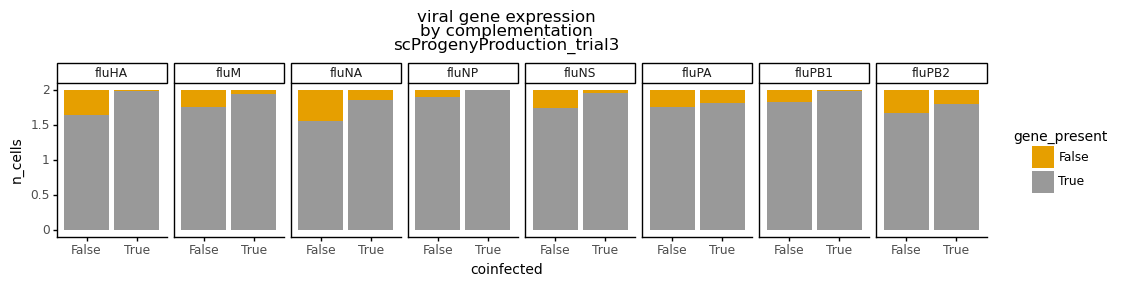

<ggplot: (8765606448171)>

In [118]:
fig = (p9.ggplot(each_gene_coinfected_normalized,
                 p9.aes(x='factor(coinfected)',
                        y='frac_cells',
                        fill='gene_present')) +
       p9.geom_bar(stat='identity') +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'by complementation\n'
                  f'{expt}') +
       p9.labs(x='coinfected',
               y='n_cells') +
       p9.theme(figure_size=(12, 2),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

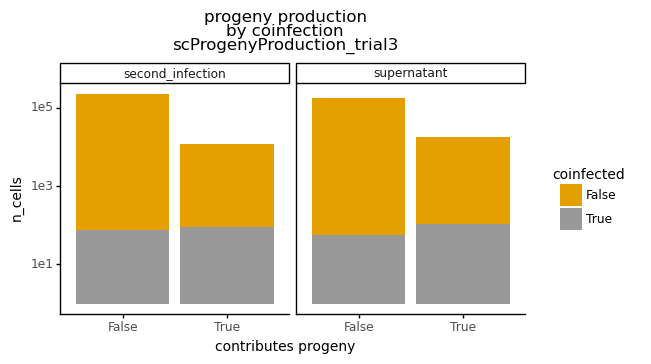

<ggplot: (8765622224442)>

In [119]:
fig = (p9.ggplot(viral_bc_freqs[['cell_barcode', 'coinfected', 'source', 'contributes_source_progeny']].drop_duplicates(),
                 p9.aes(x='factor(contributes_source_progeny)',
                        fill='coinfected')) +
       p9.geom_bar(stat='count') +
       p9.facet_grid('~source') +
       p9.scale_y_log10() +
       p9.ggtitle(f'progeny production\n'
                  f'by coinfection\n'
                  f'{expt}') +
       p9.labs(x='contributes progeny',
               y='n_cells') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual([CBPALETTE[1],CBPALETTE[0]]))
display(fig)

Plot number of viral genes detected in each cell by coinfection status:

In [120]:
n_genes_coinfection_summarized = (
    viral_bc_freqs
    .query('infected == "infected" and '
           'infecting_viral_tag != "both"')
    .groupby(['gene', 'coinfected', 'n_viral_genes_present'])
    ['cell_barcode']
    .nunique()
    .reset_index(name='n_cells')
)

n_genes_coinfection_normalized = pd.merge(
    left=n_genes_coinfection_summarized,
    right=(n_genes_coinfection_summarized
           .groupby(['gene', 'coinfected'])
           ['n_cells']
           .sum()
           .reset_index()
           .rename(columns={'n_cells':'total'})),
    on=['gene', 'coinfected'],
    how='left',
    validate='many_to_one'
)

n_genes_coinfection_normalized['frac_cells'] = (
    n_genes_coinfection_normalized['n_cells'] /
    n_genes_coinfection_normalized['total'])

n_genes_coinfection_normalized

gene  coinfected  n_viral_genes_present  n_cells  total  frac_cells
0   fluHA       False                    1.0        1    273    0.003663
1   fluHA       False                    2.0        1    273    0.003663
2   fluHA       False                    3.0        3    273    0.010989
3   fluHA       False                    4.0        9    273    0.032967
4   fluHA       False                    5.0       17    273    0.062271
5   fluHA       False                    6.0       35    273    0.128205
6   fluHA       False                    7.0      108    273    0.395604
7   fluHA       False                    8.0       99    273    0.362637
8   fluHA        True                    4.0        1    137    0.007299
9   fluHA        True                    5.0        1    137    0.007299
10  fluHA        True                    6.0        5    137    0.036496
11  fluHA        True                    7.0       29    137    0.211679
12  fluHA        True                    8.0      101    137    0.737226
13  fluNA       False                    1.0        1    273    0.003663
14  fluNA       False                    2.0        1    273    0.003663
15  fluNA       False                    3.0        3    273    0.010989
16  fluNA       False                    4.0        9    273    0.032967
17  fluNA       False                    5.0       17    273    0.062271
18  fluNA       False                    6.0       35    273    0.128205
19  fluNA       False                    7.0      108    273    0.395604
20  fluNA       False                    8.0       99    273    0.362637
21  fluNA        True                    4.0        1    137    0.007299
22  fluNA        True                    5.0        1    137    0.007299
23  fluNA        True                    6.0        5    137    0.036496
24  fluNA        True                    7.0       29    137    0.211679
25  fluNA        True                    8.0      101    137    0.737226

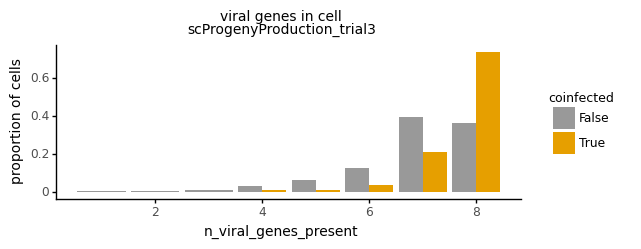

<ggplot: (8765619970018)>

In [121]:
fig = (p9.ggplot(n_genes_coinfection_normalized,
                 p9.aes(x='n_viral_genes_present',
                        y='frac_cells',
                        fill='coinfected')) +
              p9.geom_bar(stat='identity', position='dodge') +
              p9.ggtitle('viral genes in cell\n'
                         f'{expt}') +
              p9.ylab('proportion of cells') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

## Pac Bio Mutations

Import called mutations from valid PacBio CCS's:

In [122]:
pacbio_mutations = pd.read_csv(pacbio_mutations_csv, na_filter=False)
pacbio_mutations = pacbio_mutations.rename(
    columns={'cellbarcode_sequence': 'cell_barcode',
             'transcript': 'gene',
             'UMI_sequence': 'UMI',
             'viral_barcode_sequence': 'viral_barcode',
             'all_mutations_delsMerge': 'mutations'})

display(pacbio_mutations)

cell_barcode    gene           UMI  \
0       ATTATCCCATGGGTTT   fluHA  AATAACTGAAAG   
1       ATTATCCCATGGGTTT   fluHA  GGTGATTAACCT   
2       ATTATCCCATGGGTTT    fluM  AAAGTCTTTCAG   
3       ATTATCCCATGGGTTT    fluM  AAATAGTAACAG   
4       ATTATCCCATGGGTTT    fluM  AACGGAGGCGGC   
...                  ...     ...           ...   
610713  GTCTCACAGGCCCAAA  fluPB1  TTGACAGATCCA   
610714  GTCTCACAGGCCCAAA  fluPB2  AAATGCGGTTGG   
610715  GTCTCACAGGCCCAAA  fluPB2  AAGACTAAGTAA   
610716  GTCTCACAGGCCCAAA  fluPB2  ATATGCGGTTGG   
610717  GTCTCACAGGCCCAAA  fluPB2  CAATTGGATTTG   

                                 mutations  variant_call_support  
0       C608T A924T del1252to1701 ins1136C                     1  
1                                                              1  
2                                                              1  
3                                    T117C                     1  
4                                  ins368A                     1  
...                                    ...                   ...  
610713                              T1793C                    15  
610714                       del1501to1501                     1  
610715                        del558to2280                     1  
610716                       del1501to1501                     4  
610717                        del553to2280                     1  

[610718 rows x 5 columns]

Count the number of genes detected in each cell:

In [123]:
n_genes_pacbio = (pacbio_mutations
                  .groupby('cell_barcode')['gene']
                  .nunique()
                  .reset_index()
                  .rename(columns={'gene': 'n_genes_detected'}))

pacbio_mutations = pd.merge(
    left=pacbio_mutations,
    right=n_genes_pacbio,
    on=['cell_barcode'],
    how='left',
    validate='many_to_one'
)

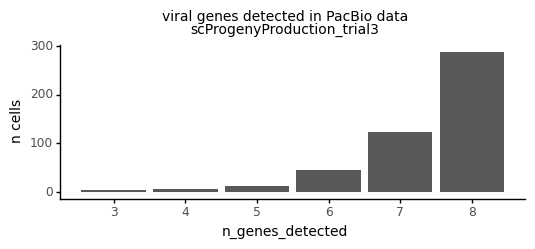

<ggplot: (8765606474677)>

In [124]:
pacbio_genes_per_cell = (
    pacbio_mutations
   .groupby('n_genes_detected')
   ['cell_barcode']
   .nunique()
   .reset_index()
   .rename(columns={'cell_barcode': 'n_cells'}))

assert  pacbio_genes_per_cell['n_cells'].sum() == \
        pacbio_mutations['cell_barcode'].nunique() , \
        "Total number of cells has changed during this operation"

fig = (p9.ggplot(pacbio_genes_per_cell,
                 p9.aes(x='n_genes_detected',
                        y='n_cells')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('viral genes detected in PacBio data\n'
                         f'{expt}') +
              p9.scale_x_continuous(breaks=range(0,10)) +
              p9.ylab('n cells') +
              p9.theme(figure_size=(6, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center'))
display(fig)

Which gene is missing when not all genes are detected?

In [125]:
transcriptome_genes_detected = (
    viral_gene_expression_long
    .query('infected == "infected" and '
           'gene_present == True')
    [['cell_barcode', 'gene']]
    .drop_duplicates())
transcriptome_genes_detected['transcriptome_detected'] = True

pacbio_genes_detected = (
    pacbio_mutations[['cell_barcode', 'gene']]
    .drop_duplicates())
pacbio_genes_detected['pacbio_detected'] = True

In [126]:
genes_detected = (pd.merge(
    left=transcriptome_genes_detected,
    right=pacbio_genes_detected,
    how='outer',
    on=['cell_barcode', 'gene'])
    .fillna(False)
)

display(genes_detected)

cell_barcode    gene  transcriptome_detected  pacbio_detected
0     AAACGAAGTACTTCCC  fluPB2                    True             True
1     AAAGGATTCTGATGGT  fluPB2                    True             True
2     AAAGGGCCAGGCTACC  fluPB2                    True             True
3     AAAGGGCTCCGCACTT  fluPB2                    True             True
4     AAAGTCCAGTAGAGTT  fluPB2                    True             True
...                ...     ...                     ...              ...
3601  GTCACGGCAACCCTAA  fluPB2                   False             True
3602  GAGGCCTGTCGGTGAA  fluPB1                   False             True
3603  GATTCGAAGCACCGAA  fluPB2                   False             True
3604  AGGCATTTCTCTTCAA  fluPB2                   False             True
3605  ACTGTCCTCCGTCAAA  fluPB1                   False             True

[3606 rows x 4 columns]

In [127]:
conditions = [
    ((genes_detected['transcriptome_detected'] == True) & 
     (genes_detected['pacbio_detected'] == False)),
    ((genes_detected['transcriptome_detected'] == False) &
     (genes_detected['pacbio_detected'] == True)),
    ((genes_detected['transcriptome_detected'] == True) &
     (genes_detected['pacbio_detected'] == True))
]
values = ['transcriptome', 'pacbio', 'both']

genes_detected['gene_detected'] = numpy.select(conditions, values)
genes_detected

cell_barcode    gene  transcriptome_detected  pacbio_detected  \
0     AAACGAAGTACTTCCC  fluPB2                    True             True   
1     AAAGGATTCTGATGGT  fluPB2                    True             True   
2     AAAGGGCCAGGCTACC  fluPB2                    True             True   
3     AAAGGGCTCCGCACTT  fluPB2                    True             True   
4     AAAGTCCAGTAGAGTT  fluPB2                    True             True   
...                ...     ...                     ...              ...   
3601  GTCACGGCAACCCTAA  fluPB2                   False             True   
3602  GAGGCCTGTCGGTGAA  fluPB1                   False             True   
3603  GATTCGAAGCACCGAA  fluPB2                   False             True   
3604  AGGCATTTCTCTTCAA  fluPB2                   False             True   
3605  ACTGTCCTCCGTCAAA  fluPB1                   False             True   

     gene_detected  
0             both  
1             both  
2             both  
3             both  
4             both  
...            ...  
3601        pacbio  
3602        pacbio  
3603        pacbio  
3604        pacbio  
3605        pacbio  

[3606 rows x 5 columns]

What is the concordance of detection for each gene?

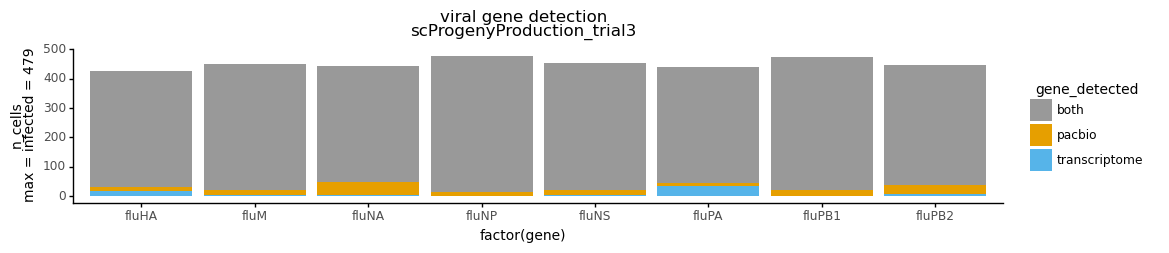

<ggplot: (8765620346103)>

In [128]:
n_infected_cells = genes_detected['cell_barcode'].nunique()
fig = (p9.ggplot(genes_detected,
                 p9.aes(x='factor(gene)',
                        fill='gene_detected')) +
       p9.geom_bar(stat='count') +
       p9.ggtitle(f'viral gene detection\n'
                  f'{expt}') +
       p9.labs(y='n_cells\n'
                 f'max = infected = {n_infected_cells}') +
       p9.theme(figure_size=(12, 2),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

### Per-cell variant frequencies
Examine viral genes in each cell to see if variants are found above treshold frequencies (e.g. 50%).

In [129]:
pacbio_mutations

cell_barcode    gene           UMI  \
0       ATTATCCCATGGGTTT   fluHA  AATAACTGAAAG   
1       ATTATCCCATGGGTTT   fluHA  GGTGATTAACCT   
2       ATTATCCCATGGGTTT    fluM  AAAGTCTTTCAG   
3       ATTATCCCATGGGTTT    fluM  AAATAGTAACAG   
4       ATTATCCCATGGGTTT    fluM  AACGGAGGCGGC   
...                  ...     ...           ...   
610713  GTCTCACAGGCCCAAA  fluPB1  TTGACAGATCCA   
610714  GTCTCACAGGCCCAAA  fluPB2  AAATGCGGTTGG   
610715  GTCTCACAGGCCCAAA  fluPB2  AAGACTAAGTAA   
610716  GTCTCACAGGCCCAAA  fluPB2  ATATGCGGTTGG   
610717  GTCTCACAGGCCCAAA  fluPB2  CAATTGGATTTG   

                                 mutations  variant_call_support  \
0       C608T A924T del1252to1701 ins1136C                     1   
1                                                              1   
2                                                              1   
3                                    T117C                     1   
4                                  ins368A                     1   
...                                    ...                   ...   
610713                              T1793C                    15   
610714                       del1501to1501                     1   
610715                        del558to2280                     1   
610716                       del1501to1501                     4   
610717                        del553to2280                     1   

        n_genes_detected  
0                      8  
1                      8  
2                      8  
3                      8  
4                      8  
...                  ...  
610713                 8  
610714                 8  
610715                 8  
610716                 8  
610717                 8  

[610718 rows x 6 columns]

Convert from haplotype to mutation. Drop WT rows.

In [130]:
mut_data = (pacbio_mutations
            .copy()
            .drop(columns=['variant_call_support', 'n_genes_detected']))
mut_data['muts_split'] = (mut_data['mutations']
                          .transform(lambda x: x.split(' ')))
mut_data = mut_data.explode('muts_split')
mut_data = mut_data.query('muts_split != ""')

mut_data

cell_barcode    gene           UMI  \
0       ATTATCCCATGGGTTT   fluHA  AATAACTGAAAG   
0       ATTATCCCATGGGTTT   fluHA  AATAACTGAAAG   
0       ATTATCCCATGGGTTT   fluHA  AATAACTGAAAG   
0       ATTATCCCATGGGTTT   fluHA  AATAACTGAAAG   
3       ATTATCCCATGGGTTT    fluM  AAATAGTAACAG   
...                  ...     ...           ...   
610713  GTCTCACAGGCCCAAA  fluPB1  TTGACAGATCCA   
610714  GTCTCACAGGCCCAAA  fluPB2  AAATGCGGTTGG   
610715  GTCTCACAGGCCCAAA  fluPB2  AAGACTAAGTAA   
610716  GTCTCACAGGCCCAAA  fluPB2  ATATGCGGTTGG   
610717  GTCTCACAGGCCCAAA  fluPB2  CAATTGGATTTG   

                                 mutations     muts_split  
0       C608T A924T del1252to1701 ins1136C          C608T  
0       C608T A924T del1252to1701 ins1136C          A924T  
0       C608T A924T del1252to1701 ins1136C  del1252to1701  
0       C608T A924T del1252to1701 ins1136C       ins1136C  
3                                    T117C          T117C  
...                                    ...            ...  
610713                              T1793C         T1793C  
610714                       del1501to1501  del1501to1501  
610715                        del558to2280   del558to2280  
610716                       del1501to1501  del1501to1501  
610717                        del553to2280   del553to2280  

[565294 rows x 5 columns]

Get n UMIs with each mutation:

In [131]:
mut_UMIs = (
    mut_data
    .groupby(['cell_barcode','gene','muts_split'])
    ['UMI']
    .nunique()
    .reset_index()
    .rename(columns={'muts_split': 'mutation',
                     'UMI': 'variant_call_support'}))

mut_UMIs

cell_barcode    gene  \
0       AAACGAAGTACTTCCC    fluM   
1       AAACGAAGTACTTCCC    fluM   
2       AAACGAAGTACTTCCC    fluM   
3       AAACGAAGTACTTCCC    fluM   
4       AAACGAAGTACTTCCC    fluM   
...                  ...     ...   
250371  TTTGGAGGTATCGTTG  fluPB2   
250372  TTTGGAGGTATCGTTG  fluPB2   
250373  TTTGGAGGTATCGTTG  fluPB2   
250374  TTTGGAGGTATCGTTG  fluPB2   
250375  TTTGGAGGTATCGTTG  fluPB2   

                                                 mutation  \
0                                                   A111C   
1                                                   A119G   
2                                                   A208G   
3                                                   A216T   
4                                                   A277G   
...                                                   ...   
250371                                             T2293A   
250372                                      del2129to2280   
250373  ins2128ATCAATGAACTGAGCAATCTTGCAAAAGGAGAGAAGGCT...   
250374  ins2292CCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
250375                                            ins516G   

        variant_call_support  
0                          2  
1                          1  
2                          2  
3                          1  
4                          1  
...                      ...  
250371                     1  
250372                     2  
250373                     1  
250374                     1  
250375                     1  

[250376 rows x 4 columns]

Get fraction of UMIs in each cell with each mutation:

In [132]:
mut_frequencies = pd.merge(
    left=mut_UMIs,
    right=(pacbio_mutations  #  Must be original dataframe to include WT UMIs
           .groupby(['cell_barcode', 'gene'])
           ['UMI']
           .nunique()
           .reset_index()
           .rename(columns={'UMI': 'total_UMIs'})),
    how='left',
    on=['cell_barcode', 'gene'],
    validate='many_to_one'
)
mut_frequencies['frac_UMIs'] = (
    mut_frequencies['variant_call_support'] /
    mut_frequencies['total_UMIs'])


mut_frequencies

cell_barcode    gene  \
0       AAACGAAGTACTTCCC    fluM   
1       AAACGAAGTACTTCCC    fluM   
2       AAACGAAGTACTTCCC    fluM   
3       AAACGAAGTACTTCCC    fluM   
4       AAACGAAGTACTTCCC    fluM   
...                  ...     ...   
250371  TTTGGAGGTATCGTTG  fluPB2   
250372  TTTGGAGGTATCGTTG  fluPB2   
250373  TTTGGAGGTATCGTTG  fluPB2   
250374  TTTGGAGGTATCGTTG  fluPB2   
250375  TTTGGAGGTATCGTTG  fluPB2   

                                                 mutation  \
0                                                   A111C   
1                                                   A119G   
2                                                   A208G   
3                                                   A216T   
4                                                   A277G   
...                                                   ...   
250371                                             T2293A   
250372                                      del2129to2280   
250373  ins2128ATCAATGAACTGAGCAATCTTGCAAAAGGAGAGAAGGCT...   
250374  ins2292CCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
250375                                            ins516G   

        variant_call_support  total_UMIs  frac_UMIs  
0                          2         435   0.004598  
1                          1         435   0.002299  
2                          2         435   0.004598  
3                          1         435   0.002299  
4                          1         435   0.002299  
...                      ...         ...        ...  
250371                     1           8   0.125000  
250372                     2           8   0.250000  
250373                     1           8   0.125000  
250374                     1           8   0.125000  
250375                     1           8   0.125000  

[250376 rows x 6 columns]

Call consensus mutations:

In [133]:
mut_frequencies['freq_50_mut'] = (
    mut_frequencies['frac_UMIs'] > 0.5
)

mut_frequencies['freq_25_mut'] = (
    mut_frequencies['frac_UMIs'] > 0.25
)

mut_frequencies

cell_barcode    gene  \
0       AAACGAAGTACTTCCC    fluM   
1       AAACGAAGTACTTCCC    fluM   
2       AAACGAAGTACTTCCC    fluM   
3       AAACGAAGTACTTCCC    fluM   
4       AAACGAAGTACTTCCC    fluM   
...                  ...     ...   
250371  TTTGGAGGTATCGTTG  fluPB2   
250372  TTTGGAGGTATCGTTG  fluPB2   
250373  TTTGGAGGTATCGTTG  fluPB2   
250374  TTTGGAGGTATCGTTG  fluPB2   
250375  TTTGGAGGTATCGTTG  fluPB2   

                                                 mutation  \
0                                                   A111C   
1                                                   A119G   
2                                                   A208G   
3                                                   A216T   
4                                                   A277G   
...                                                   ...   
250371                                             T2293A   
250372                                      del2129to2280   
250373  ins2128ATCAATGAACTGAGCAATCTTGCAAAAGGAGAGAAGGCT...   
250374  ins2292CCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
250375                                            ins516G   

        variant_call_support  total_UMIs  frac_UMIs  freq_50_mut  freq_25_mut  
0                          2         435   0.004598        False        False  
1                          1         435   0.002299        False        False  
2                          2         435   0.004598        False        False  
3                          1         435   0.002299        False        False  
4                          1         435   0.002299        False        False  
...                      ...         ...        ...          ...          ...  
250371                     1           8   0.125000        False        False  
250372                     2           8   0.250000        False        False  
250373                     1           8   0.125000        False        False  
250374                     1           8   0.125000        False        False  
250375                     1           8   0.125000        False        False  

[250376 rows x 8 columns]

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 18 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


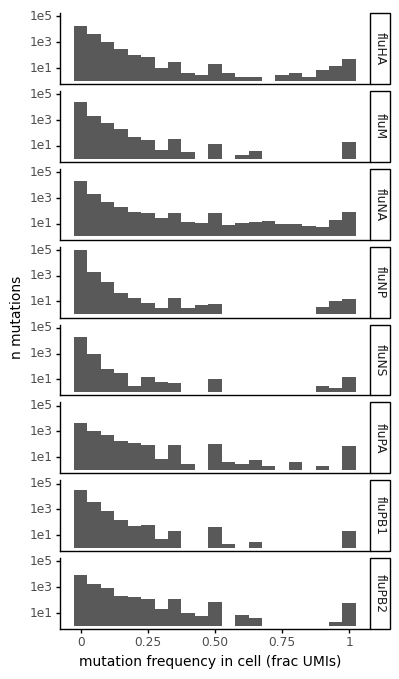

<ggplot: (8765620303722)>

In [134]:
fig = (p9.ggplot(mut_frequencies,
                 p9.aes(x='frac_UMIs')) +
              p9.geom_histogram(binwidth=0.05) +
              p9.facet_grid('gene~') +
              p9.scale_y_log10() +
              p9.labs(x='mutation frequency in cell (frac UMIs)',
                      y='n mutations') +
              p9.theme(figure_size=(4, 8),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

In [135]:
freq_50_muts_by_cell = (
    mut_frequencies
    .query('freq_50_mut == True')
    .groupby(['cell_barcode', 'gene'])
    .agg({'mutation': lambda x: " ".join(x)})
    .rename(columns={'mutation': 'freq_50_mutations'})
    .reset_index())

freq_25_muts_by_cell = (
    mut_frequencies
    .query('freq_25_mut == True')
    .groupby(['cell_barcode', 'gene'])
    .agg({'mutation': lambda x: " ".join(x)})
    .rename(columns={'mutation': 'freq_25_mutations'})
    .reset_index())

mut_freqs_by_cell = pd.merge(
    left=freq_50_muts_by_cell,
    right=freq_25_muts_by_cell,
    on=['cell_barcode', 'gene'],
    how='outer'
)

consensus_muts_by_cell = pd.merge(
    left=pacbio_genes_detected[['cell_barcode', 'gene']],
    right=mut_freqs_by_cell,
    on=['cell_barcode', 'gene'],
    how='outer',
    validate='one_to_many'
)

consensus_muts_by_cell = consensus_muts_by_cell.fillna("None")

consensus_muts_by_cell

cell_barcode    gene freq_50_mutations  \
0     ATTATCCCATGGGTTT   fluHA              None   
1     ATTATCCCATGGGTTT    fluM              None   
2     ATTATCCCATGGGTTT   fluNA              None   
3     ATTATCCCATGGGTTT   fluNP              None   
4     ATTATCCCATGGGTTT   fluNS              None   
...                ...     ...               ...   
3531  GTCTCACAGGCCCAAA   fluNP            A1356G   
3532  GTCTCACAGGCCCAAA   fluNS              None   
3533  GTCTCACAGGCCCAAA   fluPA             G885T   
3534  GTCTCACAGGCCCAAA  fluPB1              None   
3535  GTCTCACAGGCCCAAA  fluPB2              None   

                                   freq_25_mutations  
0                 A924T C608T del1252to1701 ins1136C  
1                                               None  
2                                               None  
3                                               None  
4                                               None  
...                                              ...  
3531                                          A1356G  
3532                                            None  
3533  C821T G885T del1141to1141 del680to680 ins1504G  
3534                                            None  
3535                                   del1501to1501  

[3536 rows x 4 columns]

In [136]:
contribute_progeny = (
 viral_bc_freqs
 .query('(cell_barcode.notnull()) & infected == "infected"', engine='python')
 [['cell_barcode',
   'infected',
   'frac_viral_UMIs',
   'n_viral_genes_present',
   'source',
   'contributes_source_progeny']]
 .pivot_table('contributes_source_progeny',
              ['cell_barcode', 'infected', 'frac_viral_UMIs', 'n_viral_genes_present'],
              'source')
 .reset_index()
 [['cell_barcode', 'supernatant']])

contribute_progeny

source      cell_barcode  supernatant
0       AAACGAAGTACTTCCC        False
1       AAACGAAGTAGACGTG         True
2       AAAGGATTCTGATGGT         True
3       AAAGGGCCAGGCTACC         True
4       AAAGGGCTCCGCACTT         True
..                   ...          ...
474     TTTAGTCCATCATCCC        False
475     TTTAGTCGTGCTCCGA        False
476     TTTCACAAGCCAAGCA        False
477     TTTGATCTCGCATTGA        False
478     TTTGGAGGTATCGTTG         True

[479 rows x 2 columns]

In [137]:
consensus_muts_by_cell = pd.merge(
    left=consensus_muts_by_cell,
    right=contribute_progeny,
    on=['cell_barcode'],
    how='left',
    validate='many_to_one'
)

consensus_muts_by_cell

cell_barcode    gene freq_50_mutations  \
0     ATTATCCCATGGGTTT   fluHA              None   
1     ATTATCCCATGGGTTT    fluM              None   
2     ATTATCCCATGGGTTT   fluNA              None   
3     ATTATCCCATGGGTTT   fluNP              None   
4     ATTATCCCATGGGTTT   fluNS              None   
...                ...     ...               ...   
3531  GTCTCACAGGCCCAAA   fluNP            A1356G   
3532  GTCTCACAGGCCCAAA   fluNS              None   
3533  GTCTCACAGGCCCAAA   fluPA             G885T   
3534  GTCTCACAGGCCCAAA  fluPB1              None   
3535  GTCTCACAGGCCCAAA  fluPB2              None   

                                   freq_25_mutations  supernatant  
0                 A924T C608T del1252to1701 ins1136C         True  
1                                               None         True  
2                                               None         True  
3                                               None         True  
4                                               None         True  
...                                              ...          ...  
3531                                          A1356G        False  
3532                                            None        False  
3533  C821T G885T del1141to1141 del680to680 ins1504G        False  
3534                                            None        False  
3535                                   del1501to1501        False  

[3536 rows x 5 columns]

Export to CSV:

In [138]:
(consensus_muts_by_cell
 [['supernatant', 'cell_barcode', 'gene', 'freq_50_mutations']]
 .sort_values(by=['supernatant', 'cell_barcode', 'gene'])
 .to_csv(consensus_muts_by_cell_csv, index=False)
)

Plot n cells with WT consensus for each gene

In [139]:
consensus_muts_by_cell['WT'] = (
    consensus_muts_by_cell['freq_50_mutations'] == "None"
)

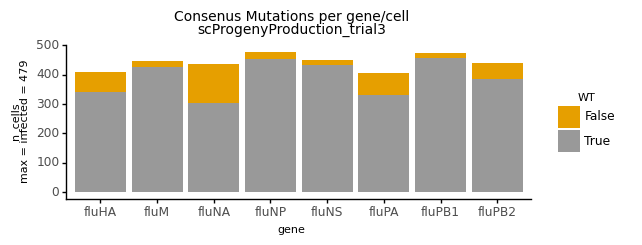

<ggplot: (8766305697037)>

In [140]:
n_infected_cells = genes_detected['cell_barcode'].nunique()
fig = (p9.ggplot(consensus_muts_by_cell,
                 p9.aes(x='gene',
                        fill='WT')) +
       p9.geom_bar(stat='count') +
       p9.ggtitle(f'Consenus Mutations per gene/cell\n'
                  f'{expt}') +
       p9.labs(y='n_cells\n'
                 f'max = infected = {n_infected_cells}') +
       p9.theme(figure_size=(6, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=8),
                legend_title=p9.element_text(size=8),
                legend_title_align='center') +
       p9.scale_fill_manual([CBPALETTE[1], CBPALETTE[0]]))
display(fig)

Count cells with full WT seqeunce for **all genes**.

In [141]:
complete_WT_genome = ((consensus_muts_by_cell
                       .query('freq_50_mutations == "None"')
                       .groupby('cell_barcode')
                       ['gene']
                       .nunique() == 8)
                      .reset_index(name='complete_WT_genome'))

complete_WT_genome = pd.merge(
    left=complete_WT_genome,
    right=contribute_progeny,
    on='cell_barcode',
    how='left',
    validate='one_to_one'
)

display(complete_WT_genome)

cell_barcode  complete_WT_genome  supernatant
0    AAACGAAGTACTTCCC               False        False
1    AAACGAAGTAGACGTG               False         True
2    AAAGGATTCTGATGGT               False         True
3    AAAGGGCCAGGCTACC               False         True
4    AAAGGGCTCCGCACTT               False         True
..                ...                 ...          ...
474  TTTAGTCCATCATCCC               False        False
475  TTTAGTCGTGCTCCGA               False        False
476  TTTCACAAGCCAAGCA               False        False
477  TTTGATCTCGCATTGA                True        False
478  TTTGGAGGTATCGTTG               False         True

[479 rows x 3 columns]

complete_WT_genome  supernatant  n_cells
0               False        False      229
1               False         True      139
2                True        False       36
3                True         True       75

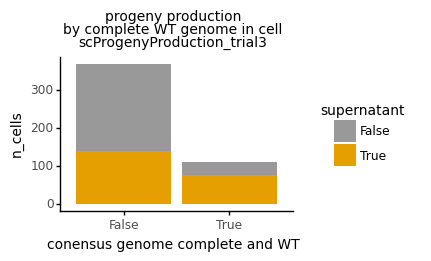

<ggplot: (8766305870288)>

In [142]:
genome_sup_counts = (complete_WT_genome
                     .groupby(['complete_WT_genome', 'supernatant'])
                     ['cell_barcode']
                     .nunique()
                     .reset_index(name='n_cells'))
display(genome_sup_counts)

fig = (p9.ggplot(genome_sup_counts,
                 p9.aes(x='complete_WT_genome',
                        y='n_cells',
                        fill='supernatant')) +
       p9.geom_bar(stat='identity') +
       p9.ggtitle(f'progeny production\n'
                  f'by complete WT genome in cell\n'
                  f'{expt}') +
       p9.labs(x='conensus genome complete and WT',
               y='n_cells') +
       p9.theme(figure_size=(3, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual([CBPALETTE[0],CBPALETTE[1]]))
display(fig)

## Export outcomes of infection
Export the summarized outcomes of infection for each cell. These are things like:  
* viral burden
* all 8 viral genes detected
* cell contributes progeny
* estimate of progeny contribution (max of top HA and NA viral bc frequencies)

In [143]:
viral_outcomes = (viral_bc_freqs
                  .query('(cell_barcode.notnull())',
                         engine='python')
                  [['cell_barcode',
                    'infected',
                    'frac_viral_UMIs',
                    'all_genes',
                    'source',
                    'contributes_source_progeny']]
                  .pivot_table('contributes_source_progeny',
                               ['cell_barcode', 'infected', 'frac_viral_UMIs', 'all_genes'],
                               'source')
                  .reset_index()
                 )

display(viral_outcomes)

source      cell_barcode    infected  frac_viral_UMIs  all_genes  \
0       AAACCCAGTAACAAGT  uninfected         0.000125      False   
1       AAACCCATCATTGCTT  uninfected         0.000111      False   
2       AAACGAAAGATGTTGA  uninfected         0.000161      False   
3       AAACGAAGTACTTCCC    infected         0.423770      False   
4       AAACGAAGTAGACGTG    infected         0.037429      False   
...                  ...         ...              ...        ...   
3367    TTTGATCTCCCGTTCA  uninfected         0.000048      False   
3368    TTTGATCTCGCATTGA    infected         0.060937       True   
3369    TTTGGAGAGTTGCCTA  uninfected         0.000182      False   
3370    TTTGGAGGTATCGTTG    infected         0.023486       True   
3371    TTTGTTGAGTGCAGCA  uninfected         0.000059      False   

source  second_infection  supernatant  
0                  False        False  
1                  False        False  
2                  False        False  
3                  False        False  
4                  False         True  
...                  ...          ...  
3367               False        False  
3368               False        False  
3369               False        False  
3370                True         True  
3371               False        False  

[3372 rows x 6 columns]

In [144]:
progeny_contributions = (
    pd.pivot_table(high_progeny,
                   index=['cell_barcode'],
                   columns='source',
                   values='progeny_freq')
      .reset_index()
      .rename(columns={'supernatant':'supernatant_freq',
                       'second_infection':'second_infection_freq'}))

viral_outcomes = (pd.merge(
    left=viral_outcomes,
    right=progeny_contributions,
    on='cell_barcode',
    how='left',
    validate='many_to_one')
    .fillna(0))

display(viral_outcomes)

source      cell_barcode    infected  frac_viral_UMIs  all_genes  \
0       AAACCCAGTAACAAGT  uninfected         0.000125      False   
1       AAACCCATCATTGCTT  uninfected         0.000111      False   
2       AAACGAAAGATGTTGA  uninfected         0.000161      False   
3       AAACGAAGTACTTCCC    infected         0.423770      False   
4       AAACGAAGTAGACGTG    infected         0.037429      False   
...                  ...         ...              ...        ...   
3367    TTTGATCTCCCGTTCA  uninfected         0.000048      False   
3368    TTTGATCTCGCATTGA    infected         0.060937       True   
3369    TTTGGAGAGTTGCCTA  uninfected         0.000182      False   
3370    TTTGGAGGTATCGTTG    infected         0.023486       True   
3371    TTTGTTGAGTGCAGCA  uninfected         0.000059      False   

source  second_infection  supernatant  second_infection_freq  supernatant_freq  
0                  False        False                0.00000          0.000000  
1                  False        False                0.00000          0.000000  
2                  False        False                0.00000          0.000000  
3                  False        False                0.00000          0.000000  
4                  False         True                0.00000          0.000291  
...                  ...          ...                    ...               ...  
3367               False        False                0.00000          0.000000  
3368               False        False                0.00000          0.000000  
3369               False        False                0.00000          0.000000  
3370                True         True                0.00004          0.001808  
3371               False        False                0.00000          0.000000  

[3372 rows x 8 columns]

In [145]:
export_csv = f'results/viral_fastq10x/{expt}_viral_outcomes.csv'

print(f'Writing viral outcomes results to {export_csv}')
viral_outcomes.to_csv(export_csv, index=False)
print('Done.')

Writing viral outcomes results to results/viral_fastq10x/scProgenyProduction_trial3_viral_outcomes.csv
Done.
